# 同花顺行业概念信息

In [1]:
import os
import pandas as pd
# https://zhuanlan.zhihu.com/p/508035138/
fpath = r'../../JohnsonUtil\wencai\同花顺板块行业.xlsx'.replace('\\',os.path.sep)
print(f'cwd:{os.getcwd()},\nfpath:{fpath}')

thsgn = pd.read_excel(fpath)
thsgn = thsgn.set_index('股票代码')


cwd:D:\MacTools\WorkFile\WorkSpace\pyQuant3\stock\jupyterAlgo\Quant2023,
fpath:../../JohnsonUtil\wencai\同花顺板块行业.xlsx


## 查询信息

In [20]:
thsgn[:1]
thsgn.columns
thsgn.loc['300474.SZ']

股票简称                                                                  景嘉微
现价(元)                                                                71.1
涨跌幅(%)                                                               0.08
主营产品名称                  图形显控领域产品||小型专用化雷达领域产品||小型专业化雷达||图形显控模块产品||加固类产...
所属概念                    华为欧拉;国家大基金持股;MCU芯片;信创;军工信息化;芯片概念;先进封装;东数西算(算力)...
所属同花顺行业                                                   国防军工-军工电子-军工电子Ⅲ
所属概念数量(个)                                                              16
a股流通市值 (元)2025.06.11                                   28899409734.900002
经营范围                    电子产品（不含电子出版物）、计算机软件的研究、开发、生产和销售及其相关的技术服务，集成电路设...
公司网站                                                 www.jingjiamicro.com
Name: 300474.SZ, dtype: object

# Debug开启

In [6]:

# Delete Jupyter notebook root logger handler
# Set Debug
import logging
import sys

# %matplotlib inline
%matplotlib widget
# stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
# # # reload(sys)
# # # sys.setdefaultencoding('utf-8')
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# stdout = sys.stdout
# sys.path.append('../')
# import JSONData.tdx_data_Day as tdd
# sys.stdout = stdout


mylogger = logging.getLogger()
if len(mylogger.handlers) > 0:
    for ix in mylogger.handlers:
        print("handlers:%s std:%s" % (ix.stream, sys.stdout))
else:
    print("nb not handlers")
#     mylogger.propagate = False
mylogger.setLevel(logging.ERROR)
# mylogger.setLevel(logging.DEBUG)

print("nb:", sys.stderr)
# # Create logger as usual
import nest_asyncio

nest_asyncio.apply()

handlers:<ipykernel.iostream.OutStream object at 0x00000276D8218130> std:<ipykernel.iostream.OutStream object at 0x00000276D82180D0>
handlers:<_io.TextIOWrapper name='G:\\stock.log.2025-09-17.log' mode='a+' encoding='cp936'> std:<ipykernel.iostream.OutStream object at 0x00000276D82180D0>
nb: <ipykernel.iostream.OutStream object at 0x00000276D8218130>


# TDX多日数据分析

## 定义 TDX-Path

In [7]:
# encoding:utf-8
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"

import sys

import pandas as pd
from pandas import HDFStore

stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
# print(stdi, stdo, stde)
# reload(sys)
# sys.setdefaultencoding('utf-8')
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# print(sys.stdout,sys.stderr,sys.stderr)

# print(stdi, stdo, stde)

# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
# print(stdi, stdo, stde)

In [8]:
sys.path.append("../../")
import os

import JSONData.tdx_data_Day as tdd
# import win_unicode_console
from JohnsonUtil import commonTips as cct
from JSONData import sina_data

os.environ['NUMEXPR_MAX_THREADS'] = '12'

# import nest_asyncio
# nest_asyncio.apply()
# 查阅资料后发现，发现使用 jupyter notebook 环境，其连接着 IPython 内核，而 IPython 内核本身在事件循环上运行，而 asyncio 不允许嵌套其事件​​循环，因此会出现如上图的错误信息。
# nest_asyncio 作为异步操作的补丁而存在，具体内容请参考
# win_unicode_console.disable()
tdx_path = "G:\\tdx_last_df.h5"
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
sina_d_path = "G:\\sina_data.h5"
sina_dd_path = "G:\\get_sina_all_dd.h5"
# print(stdi, stdo, stde)
sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# # 显示所有列
pd.set_option("display.max_columns", None)
# # 显示所有行
# pd.set_option('display.max_rows', None)
# # 设置 value 的显示长度为 100，默认为 50
# pd.set_option('max_colwidth',100)
# pd.set_option?
# df.columns.tolist()

## HDF 文件版本检测

In [58]:
import h5py

with h5py.File(sina_d_path, "r") as f:
    print("HDF5 file libver bounds:", f.libver)
import tables

h5 = tables.open_file(sina_d_path, "r")
print("PyTables HDF5 version:", tables.hdf5Version)
print("HDF5 file root attrs:", h5.root._v_attrs._f_list())

HDF5 file libver bounds: ('earliest', 'v110')
PyTables HDF5 version: 1.10.6
HDF5 file root attrs: []


### 检测损坏

In [59]:
import pandas as pd
import tables
import os

def check_hdf5_file(fname):
    """检测 HDF5 文件损坏情况，返回坏掉的 keys"""
    bad_keys = []
    ok_keys = []
    
    if not os.path.exists(fname):
        print(f"文件不存在: {fname}")
        return bad_keys

    try:
        with pd.HDFStore(fname, mode="r") as store:
            keys = store.keys()
            print(f"检测文件 {fname}, keys: {keys}")
            for key in keys:
                try:
                    # 尝试只读几行，避免大文件内存爆
                    df = store.select(key, start=0, stop=5)
                    ok_keys.append(key)
                except Exception as e:
                    print(f"⚠️ Key {key} 读取出错: {e}")
                    bad_keys.append(key)
    except (OSError, tables.exceptions.HDF5ExtError) as e:
        print(f"整个 HDF 文件无法打开: {e}")
        return ["<file broken>"]

    print(f"✅ 正常 keys: {ok_keys}")
    print(f"❌ 损坏 keys: {bad_keys}")
    return bad_keys
check_hdf5_file(sina_d_path)

检测文件 G:\sina_data.h5, keys: ['/all']
⚠️ Key /all 读取出错: 'UnImplemented' object has no attribute 'description'
✅ 正常 keys: []
❌ 损坏 keys: ['/all']


['/all']

### 尝试修复

In [60]:
import pandas as pd
import os

def repair_hdf5_file(src_file, dst_file=None):
    """修复 HDF5 文件，把能读的 key 导出到新文件"""
    if not os.path.exists(src_file):
        print(f"文件不存在: {src_file}")
        return
    
    if dst_file is None:
        dst_file = src_file.replace(".h5", "_fixed.h5")
    
    bad_keys = []
    ok_keys = []
    
    with pd.HDFStore(src_file, mode="r") as src:
        with pd.HDFStore(dst_file, mode="w", complevel=9, complib="blosc") as dst:
            for key in src.keys():
                try:
                    df = src.select(key)  # 全量导出
                    dst.put(key, df, format="table", complevel=9, complib="blosc")
                    ok_keys.append(key)
                    print(f"✅ 成功复制 {key} ({len(df)} 行)")
                except Exception as e:
                    print(f"❌ 读取失败 {key}: {e}")
                    bad_keys.append(key)
    
    print(f"\n修复完成，新文件: {dst_file}")
    print(f"✅ 正常 keys: {ok_keys}")
    print(f"❌ 损坏 keys: {bad_keys}")
    return dst_file, ok_keys, bad_keys
repair_hdf5_file(sina_d_path)

❌ 读取失败 /all: 'UnImplemented' object has no attribute 'description'

修复完成，新文件: G:\sina_data_fixed.h5
✅ 正常 keys: []
❌ 损坏 keys: ['/all']


('G:\\sina_data_fixed.h5', [], ['/all'])

In [9]:
cct.code_to_symbol_ths('000002')

'000002.SZ'

### 功能定义

In [10]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df


def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df


def write_code_to_blk(codew, blk='090'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))


def show_tdx_data(df, codelist=None, market_value='3', col=None):

    columns_ = [
        "name", "category", "close", "percent",'volra', 'topR', "lastp1d", "ma5dcum",
        "ma20d", "fib", "fibl", "ra", "ral", "df2", "per1d", "hmax", "lmin",
        "per%sd" % (market_value),
        "perc%sd" % (market_value)]
    if isinstance(df, pd.Series):
        columns_ = [co for co in columns_ if co in df.index]
    else:
        columns_ = [co for co in columns_ if co in df.columns]
    if col is not None:
        columns_.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            # print("Count:1")
            temp = df.loc[columns_]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, columns_]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], columns_]
    return temp


def compute_perd_value(df, market_value=3, col="per"):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col))
                & (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df


from collections import Counter, OrderedDict


def counterCategory(df):
    top5 = dict()
    if len(df) > 0:
        categoryl = df.category[:20].tolist()
        dicSort = []
        for i in categoryl:
            if isinstance(i, str):
                # dicSort.extend([ co.decode('utf8') for co in i.split(';')])
                dicSort.extend(i.split(';'))
                # cate_list = i.split(';')
                # for co in cate_list:
                #     dicSort.append(to_str(co))
        topSort = Counter(dicSort)
        top5 = OrderedDict(topSort.most_common(5))
        # for i in top5.keys():
        # print(i, top5[i]),
        # print('')
    # for i in top5.keys():
    #     # print(u"板块:%s %s " % (i.decode('utf8'), (topSort[i]))),
    #     # print(u"板块:%s count:%s" % (i, (topSort[i]))),
    #     print(i, (topSort[i]))

    return top5


def get_runtime_percent(df, perd=None):
    if "percent" not in df.columns and "lastp1d" in df.columns:
        # print('init percent')
        df = df.fillna(0)
        df['percent'] = list(
            map(
                lambda x, y, z: round((x - y) / y * 100, 1)
                if x != y else round((x - z) / z * 100, 1),
                df.close, df.lastp1d, df.lastp2d))
        # df['percent'] = df.apply(lambda x: round((x.close - x.lastp1d) /(x.lastp1d) * 100, 1),axis=1)
    # else:
    #     print('Percent in columns')
    if not perd is None:
        df[perd] = list(map(lambda x, y: round((x + y), 1)
                            if int(y) > 0 else 0, df.perd, df.percent))
    return df


def get_realtime_ratio(df, market='all'):
    if 'ratio' in df.columns:
        df.drop('ratio', axis=1, inplace=True)
    ratio_df = tdd.getSinaJsondf(market)
    df = cct.combine_dataFrame(
        df, ratio_df.ratio, col=None, compare=None, append=False, clean=False)
    return df


def get_ths_info(code):
    code = cct.code_to_symbol_ths(code)
    return thsgn.loc[code]

### 还原Cell输出信息

In [11]:
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
# print(stdi, stdo, stde)

## 初始化 hdf5的tdx数据

In [12]:

market_value = "3"
df = readHdf5(tdx_path)
df = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
df = compute_perd_value(df, market_value, "perc")
df = compute_perd_value(df, market_value, "per")

df = get_realtime_ratio(df)
# df=get_runtime_percent(df)

df = get_runtime_percent(df, "per%sd" % (market_value))

# filter 科创
# df = clean_688(df)

df.shape
df[-1:].percent
df[~(df.last6vol > 0)][:10].last6vol
df.ratio[-2:]

['/low_3d_120_y_all', '/low_d_60_y_all', '/low_m_300_y_all', '/low_w_200_y_all']


(5192, 209)

code
688981    7.0
Name: percent, dtype: float64

Series([], Name: last6vol, dtype: float64)

code
688819    0.6
688981    7.7
Name: ratio, dtype: float64

### test InStock

In [14]:
df.columns.values

array(['lopen', 'lhigh', 'llow', 'lastp', 'lvol', 'lamount', 'lower',
       'ene', 'upper', 'bandwidth', 'bollpect', 'macd', 'macddif',
       'macddea', 'macdlast1', 'macdlast2', 'macdlast3', 'macdlast4',
       'macdlast5', 'macdlast6', 'ma5d', 'ma10d', 'ma20d', 'ma60d',
       'truer', 'op', 'ldate', 'topU', 'eneU', 'upperT', 'upperL',
       'percmax', 'df2', 'red', 'gren', 'top0', 'top15', 'topR', 'topD',
       'ral', 'perd', 'perlastp', 'fibl', 'boll', 'ra', 'kdj', 'rsi',
       'ma', 'oph', 'rah', 'vchange', 'vcra', 'vcall', 'lasto1d',
       'lastl1d', 'truer1d', 'lasth1d', 'lastp1d', 'lastv1d', 'per1d',
       'upper1', 'ma51d', 'ma201d', 'ma601d', 'perc1d', 'lasto2d',
       'lastl2d', 'truer2d', 'lasth2d', 'lastp2d', 'lastv2d', 'per2d',
       'upper2', 'ma52d', 'ma202d', 'ma602d', 'perc2d', 'lasto3d',
       'lastl3d', 'truer3d', 'lasth3d', 'lastp3d', 'lastv3d', 'per3d',
       'upper3', 'ma53d', 'ma203d', 'ma603d', 'perc3d', 'lasto4d',
       'lastl4d', 'truer4d', 'lasth

### GPT

In [38]:
factors = {
    "momentum": [   # 动量/波动
        "percmax", "perc1d", "perc2d", "perc3d", "perc5d", "perc10d",
        "maxp", "fib", "fibl", "lastdu4",
        "hmax", "high4", "low4", "max5", "max10", "hmax60",
        "low10", "low60", "lmin"
    ],
    "volume": [     # 量能
        "turnover", "vchange", "vcra", "vcall",
        "hv", "lv", "llowvol", "hmaxvol", "last6vol"
    ],
    "trend": [      # 均线 & 趋势
        "ma5d", "ma10d", "ma20d", "ma60d",
        "ral", "up5", "topU", "eneU", "ene", "boll"
    ],
    "pattern": [    # K线形态 & 强弱
        "red", "green", "top0", "top15", "top10",
        "macd", "macddif", "macddea", "macdlast6",
        "truer", "cmean"
    ]
}


#### GPT Score

In [39]:
import pandas as pd
import numpy as np

def score_stocks(df, factors):
    scores = pd.DataFrame(index=df.index)

    for group, cols in factors.items():
        valid_cols = [c for c in cols if c in df.columns]
        if not valid_cols:
            continue

        # z-score 标准化
        sub_df = df[valid_cols].astype(float)
        z_scores = (sub_df - sub_df.mean()) / (sub_df.std() + 1e-9)

        # 每组得分取平均
        scores[group] = z_scores.mean(axis=1)

    # 总分（可以调权重）
    scores["total_score"] = scores.mean(axis=1)
    return scores


##### 示例

In [41]:
# 对 top_all 打分
scores = score_stocks(df, factors)

# 查看总分最高的前 20 个股票
top_rank = scores.sort_values("total_score", ascending=False).head(20)
print(top_rank)

# 合并回原始数据
top_all_with_score = pd.concat([df, scores], axis=1)


         momentum     volume      trend    pattern  total_score
code                                                           
399001  24.359905  28.497474  26.121557  31.760930    27.684966
399005  15.075841   6.306606  16.126967  17.702027    13.802860
399006   5.608459  22.499239   6.418786  11.163177    11.422415
999999   7.657203   3.688760   8.214359   5.680649     6.310243
688256   3.202594   0.285930   3.103812  11.647306     4.559910
603359   1.393000  10.555938   0.546507   1.957009     3.613114
600519   2.972579  -0.272703   3.192909   1.735082     1.906966
300308   1.206219   0.100938   1.462729   4.440857     1.802685
603444   1.509393  -0.123906   1.464897   3.209997     1.515095
300476   1.466557   0.020327   1.235315   3.272558     1.498689
301488   1.915309   0.159456   1.045634   2.746256     1.466664
688498   1.214763   0.223234   1.363600   3.000444     1.450510
300502   0.846854   0.171486   1.234133   3.460184     1.428164
688228   1.929553  -0.053169   0.691097 

#### 权重配置

In [44]:
def score_stocks_weighted(df, factors, weights=None):
    scores = pd.DataFrame(index=df.index)

    # 默认权重（均等分）
    if weights is None:
        weights = {g: 1.0 for g in factors.keys()}

    # 归一化权重
    total_w = sum(weights.values())
    weights = {g: w / total_w for g, w in weights.items()}

    for group, cols in factors.items():
        valid_cols = [c for c in cols if c in df.columns]
        if not valid_cols:
            continue

        sub_df = df[valid_cols].astype(float)
        z_scores = (sub_df - sub_df.mean()) / (sub_df.std() + 1e-9)

        # 组内平均
        scores[group] = z_scores.mean(axis=1)

    # 加权总分
    scores["total_score"] = sum(
        scores[g] * weights.get(g, 0) for g in scores.columns if g in weights
    )

    return scores


##### 使用示例

In [48]:
weights = {
    "momentum": 0.4,
    "volume": 0.3,
    "trend": 0.2,
    "pattern": 0.1
}

# 这样你可以：

# 在 情绪亢奋 的市场：momentum=0.6, volume=0.2, trend=0.1, pattern=0.1
# 在 震荡偏弱 的市场：trend=0.4, pattern=0.3, volume=0.2, momentum=0.1
scores = score_stocks_weighted(df, factors, weights)
print(scores.sort_values("total_score", ascending=False).head(20))


         momentum     volume      trend    pattern  total_score
code                                                           
399001  24.359905  28.497474  26.121557  31.760930    26.693608
399005  15.075841   6.306606  16.126967  17.702027    12.917914
399006   5.608459  22.499239   6.418786  11.163177    11.393230
999999   7.657203   3.688760   8.214359   5.680649     6.380446
603359   1.393000  10.555938   0.546507   1.957009     4.028984
688256   3.202594   0.285930   3.103812  11.647306     3.152310
600519   2.972579  -0.272703   3.192909   1.735082     1.919310
003004   0.197302   3.909178   0.432571  -0.079818     1.330207
301488   1.915309   0.159456   1.045634   2.746256     1.297713
300308   1.206219   0.100938   1.462729   4.440857     1.249400
603083   1.759798   0.394968   0.830530   1.975294     1.186045
603444   1.509393  -0.123906   1.464897   3.209997     1.180564
300476   1.466557   0.020327   1.235315   3.272558     1.167040
688228   1.929553  -0.053169   0.691097 

In [54]:
scores = score_stocks_weighted(df, factors, weights)

# 把 name 列合并进来
scores = scores.merge(df[['name']], on='code', how='left')

print(scores[['name', 'total_score']].sort_values("total_score", ascending=False).head(20))


         name  total_score
code                      
399001   深证成指    26.693608
399005  中小100    12.917914
399006   创业板指    11.393230
999999   上证指数     6.380446
603359   东珠生态     4.028984
688256    寒武纪     3.152310
600519   贵州茅台     1.919310
003004  *ST声迅     1.330207
301488   豪恩汽电     1.297713
300308   中际旭创     1.249400
603083  XD剑桥科     1.186045
603444    吉比特     1.180564
300476   胜宏科技     1.167040
688228    开普云     1.152557
688498   源杰科技     1.125640
688521   芯原股份     1.100726
002058  *ST威尔     1.079421
688167   炬光科技     1.053718
688577   浙海德曼     1.052280
301413    安培龙     1.034739


In [55]:
# scores = score_stocks_weighted(df, factors, weights)

# 通过 code 映射 name
# scores['name'] = scores['code'].map(df.set_index('code')['name'])

# print(scores[['name', 'total_score']].sort_values("total_score", ascending=False).head(20))


In [42]:
df.shape

(5192, 209)

## 个股数据查看

In [15]:
df.ma203d[:1]
# df.loc['003042'].loc[["category", "close"]]

code
399001    11656.0
Name: ma203d, dtype: float64

In [16]:
show_tdx_data(df.loc['003042'])
get_ths_info('003042')

name                       中农联合
category    草甘膦;供销社;乡村振兴;中俄贸易概念
close                     16.62
percent                    -1.5
topR                          0
lastp1d                   16.88
ma5dcum                    17.2
ma20d                     17.33
fib                           0
fibl                          4
ra                            0
ral                           4
df2                          17
per1d                       0.4
hmax                      18.02
lmin                      15.76
per3d                       0.0
perc3d                     17.0
Name: 003042, dtype: object

股票简称                                                                 中农联合
现价(元)                                                               17.05
涨跌幅(%)                                                              -2.07
主营产品名称                  吡虫啉||啶虫脒||烯啶虫胺||哒螨灵||低毒农药原药及其中间体||杀虫剂||杀菌剂||除草...
所属概念                                                  草甘膦;供销社;乡村振兴;中俄贸易概念
所属同花顺行业                                                      基础化工-农化制品-农药
所属概念数量(个)                                                               4
a股流通市值 (元)2025.06.11                                           2160493478
经营范围                    生物、化学农药、化工产品及仪器仪表的技术开发、技术转让、技术咨询服务；农药（不含化学危险品）...
公司网站                                                       www.sdznlh.com
Name: 003042.SZ, dtype: object

In [17]:
# df[(df.close > df.ma20d * 0.99) & (df.close < df.ma20d * 1.05)]

def filter_ma_range_df(df, ma='20', days='3'):
    dd = []
    for da in range(int(days), 0, -1):
        # print(da, ma)
        # df1 = df[ (df['lastp%sd'%(da)] > df['ma%s%sd'%(ma,da)]) & (df['lastp%sd'%(days)] < df['ma%s%sd'%(ma,da)] * 1.1)]
        df1 = df[(df['lastp%sd' % (da)] > df['ma%s%sd' % (ma, da)] * 0.99)]
        if da == days:
            dd = df1.index.tolist()
        else:
            dd = [x for x in dd if x in df1.index]

    return [x for x in set(dd)]


def get_union_list(maind, subd):
    # 筛选Main存在后切在新Sub出现
    return [x for x in maind if x in subd]

### 新农联合筛选

In [19]:
code_fs = '003042'
# show_tdx_data(df.loc['003042'])
# get_ths_info('003042')

df_f_t = df[(df.fib < 30) & (df.fibl > 6) & (df.df2 > 2) & (df.ral < -15) &
            (df.close >= df.ma5dcum) & (df.perc3d > 1.1) & (df.lastv1d > df.lastv2d) & (df.close > df.ma5d) ]

df_f_t.shape
# df_f_t.loc[code_fs][:1]
show_tdx_data(df_f_t)[:5]


(0, 209)

Count:0 209


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,


#### 写入069

In [20]:
# write_code_to_blk(df_f_t.index, '069')

In [21]:
df_ma26d = filter_ma_range_df(df, ma=20, days=5)
# 连续3日在生命线上
# df_ma26d = df[(df.fibl > 1) & (df.ra > 5)]
len(df_ma26d)
df_ma5d = filter_ma_range_df(df, ma=5, days=5)

# 连续3日在生命线上
len(df_ma5d)
df_x = get_union_list(df_ma26d, df_ma5d)
df_5dx_20d = get_union_list(df_x, df[df.ma5d < df.ma20d].index)

show_tdx_data(df.loc[df_5dx_20d])

2325

651

Count:9 209


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
002327,富安娜,电子商务;网络直播;高股息精选;深股通,7.25,-0.4,0,7.25,7.30,7.32,0,2,0,2,7,-0.4,7.50,7.18,0.0,-69.0
600773,西藏城投,石墨烯;盐湖提锂;上海国企改革;国企改革;锂电池概念;西部大开发;;沪股通,10.89,-0.5,0,10.94,10.90,11.02,0,4,0,7,11,-1.0,12.16,9.00,0.0,-46.0
603233,大参林,医药电商;医疗器械概念;沪股通;DeepSeek概念;,17.66,2.6,0,17.22,17.20,17.25,0,5,0,5,17,-0.9,17.80,15.50,1.7,15.0
000705,浙江震元,民营医院;幽门螺杆菌概念;合成生物;流感;医药电商;肝炎概念;仿制药一致性评价;三胎概念;医...,9.28,-1.4,0,9.41,9.40,9.47,0,3,0,7,9,-0.2,10.38,7.99,0.0,-23.0
605266,健之佳,医药电商;家庭医生;电子商务;西部大开发;职业教育,21.98,-0.1,0,22.00,21.70,21.80,0,5,0,6,21,0.9,22.27,20.23,0.0,26.0
600323,瀚蓝环境,生物质能发电;天然气;固废处理;污水处理;国企改革;垃圾分类;沪股通;;节能环保;氢能源;创...,27.16,1.0,0,26.88,26.59,26.80,0,3,0,8,26,-0.7,27.88,23.34,0.3,10.0
600874,创业环保,绿色电力;PPP概念;固废处理;证金持股;地下管网;污水处理;高股息精选;国企改革;雄安新区...,5.97,0.5,0,5.94,6.00,6.00,0,2,0,5,6,-0.5,6.14,5.77,0.0,-60.0
000919,金陵药业,流感;民营医院;仿制药一致性评价;医美概念;高压氧舱;国企改革;医疗器械概念;养老概念;互联...,7.10,-0.8,0,7.16,7.20,7.21,0,5,0,6,7,-0.8,7.39,6.40,0.0,-17.0
603182,嘉华股份,人造肉;粮食概念;大豆;乡村振兴,14.26,-1.0,0,14.40,14.40,14.38,0,6,0,6,14,0.5,14.91,12.56,0.0,-19.0


In [17]:
df.loc[["603068", '601377', '000725'],
       ["date", "name", "category", "percent", "close", "lastp1d", "ma5d",
        "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
        "ra", "ral", "vcall", "vcra", "vchange", "lvol", 'lv', 'lowvol',
        'last6vol', 'per%sd' % (market_value),
        'perc%sd' % (market_value),
        'perc4d']][: 3]

,date,name,category,percent,close,lastp1d,ma5d,ma5dcum,ma20d,fib,fibl,df2,per1d,hmax,lmin,ra,ral,vcall,vcra,vchange,lvol,lv,lowvol,last6vol,per3d,perc3d,perc4d
code,,,,,,,,,,,,,,,,,,,,,,,,,,,
603068,2025-01-06,博通集成,新股与次新股,-2.3,37.14,38.00,40.28,38.0,35.15,0,15,39,-7.0,43.80,26.06,0.0,16.0,514.6,3.0,-33.4,16898399.0,3893147.0,12413524.0,20903039.3,0.0,-1.8,0.0
601377,2025-01-10,兴业证券,参股新三板;MSCI概念;融资,0.5,6.17,6.14,6.14,6.0,5.98,0,11,6,-0.6,6.59,5.66,0.0,4.0,150.8,4.0,20.1,56231512.0,29007559.0,34216543.0,46146638.4,0.0,0.3,0.1
000725,2025-01-13,京东方Ａ,国开行;物联网;OLED,1.3,4.57,4.51,4.52,4.4,4.39,0,15,4,-0.9,4.58,4.13,0.0,13.0,163.4,2.0,0.2,446631391.0,290540490.0,309247905.0,423742496.4,0.4,0.4,0.0


### sort_key2 强势股 及弱势股

In [22]:

sort_key2 = "per%sd" % (market_value)
print(sort_key2)
df = df.sort_values(
    by=["perc%sd" % (market_value), sort_key2, "fib"], ascending=[0, 0, 1]
)
show_tdx_data(df)[: 5]

show_tdx_data(df)[-5:]
# df = df.sort_values(by=['perc%sd'%(market_value), 'per%sd'%(market_value),'fib'],ascending=[0,0,1])

per3d
Count:5192 209


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
002058,*ST威尔,ST板块;核电;创投;新能源汽车;石墨烯;长安汽车概念;新型工业化;特斯拉概念;股权转让(并...,26.91,2.3,5,26.31,16.41,16.50,3,9,8,13,15,10.2,23.88,11.32,12.5,266.0
603728,鸣志电器,人形机器人;减速器;智能座舱;机器人概念;同花顺新质50;新能源汽车;5G;华为概念;安防;...,78.12,8.7,1,78.12,63.81,63.59,0,9,5,12,61,8.7,71.88,52.53,17.4,240.0
002384,东山精密,同花顺果指数;PCB概念;苹果概念;特斯拉概念;消费电子概念;5G;MiniLED;小米概念...,82.62,3.7,1,79.69,59.31,59.41,1,9,5,11,66,4.3,76.38,35.34,8.0,239.0
300052,ST中青宝,云游戏;网络安全;云计算;数字孪生;虚拟现实;元宇宙;手机游戏;数字经济;阿里巴巴概念;电子...,12.51,-3.8,2,13.01,11.30,11.26,0,10,5,10,11,1.1,12.87,9.06,0.0,233.0
000981,山子高科,华为汽车;无人驾驶;汽车拆解概念;新能源汽车;比亚迪概念;减速器;物联网;高端装备;先进封装...,3.70,10.1,1,3.36,2.20,2.25,1,11,4,9,2,21.3,2.77,2.00,31.4,224.0


Count:5192 209


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
002221,东华能源,燃料电池;2024年报预增;氢能源;页岩气;核电;天然气;跨境电商;碳纤维;俄乌冲突概念;深股通;,8.45,-1.3,0,8.45,9.10,9.32,0,0,0,6,9,-1.3,10.35,8.45,0.0,-76.0
837174,宏裕包材,锂电池概念;;;国企改革,37.31,1.1,1,36.91,28.20,26.41,0,9,5,11,20,-4.5,62.94,15.15,-3.4,-78.0
600548,深高速,深圳国企改革;PPP概念;国企改革;汽车拆解概念;固废处理;参股银行;参股券商;风电;沪股通...,10.03,0.5,0,9.98,10.50,10.41,0,0,1,7,10,-1.0,10.69,10.09,0.0,-79.0
601778,晶科科技,绿色电力;光伏建筑一体化;风电;光伏概念;虚拟电厂;氢能源;储能;数据中心;腾讯概念;沪股通;,3.95,-0.5,0,3.97,4.00,3.82,0,9,4,12,3,-6.4,4.79,2.61,0.0,-84.0
301052,果麦文化,AIGC概念;IP经济(谷子经济);数据要素;文化传媒概念;元宇宙;网红经济;人工智能;数字...,68.81,-1.6,0,69.94,72.88,67.44,0,8,1,17,65,-10.5,84.31,38.50,0.0,-90.0


## filter 20D 涨幅榜 

In [23]:
# df = df[(df['close'] > df['ma20d'] * 0.98) & (df['close'] < df['ma20d'] * 1.03)]
f20df = df[(df['close'] > df['ma20d'] * 0.98)
           & (df['df2'] > 0) & (df['lastp1d'] > df['ma5d']) & (df['lasth1d'] >= df['lasth2d']) ]

f20df.shape
show_tdx_data(f20df)[: 3]
show_tdx_data(f20df)[-3:]

(1969, 209)

Count:1969 209


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
002058,*ST威尔,ST板块;核电;创投;新能源汽车;石墨烯;长安汽车概念;新型工业化;特斯拉概念;股权转让(并...,26.91,2.3,5,26.31,16.41,16.50,3,9,8,13,15,10.2,23.88,11.32,12.5,266.0
603728,鸣志电器,人形机器人;减速器;智能座舱;机器人概念;同花顺新质50;新能源汽车;5G;华为概念;安防;...,78.12,8.7,1,78.12,63.81,63.59,0,9,5,12,61,8.7,71.88,52.53,17.4,240.0
002384,东山精密,同花顺果指数;PCB概念;苹果概念;特斯拉概念;消费电子概念;5G;MiniLED;小米概念...,82.62,3.7,1,79.69,59.31,59.41,1,9,5,11,66,4.3,76.38,35.34,8.0,239.0


Count:1969 209


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
834950,迅安科技,人民币贬值受益;,23.73,-0.1,0,23.75,23.50,23.41,0,3,0,6,24,3.3,26.27,18.02,0.0,-46.0
000050,深天马Ａ,智能家居;柔性屏(折叠屏);苹果概念;OLED;华为概念;MiniLED;消费电子概念;小米...,9.81,0.7,0,9.74,9.80,9.59,0,1,0,14,9,-0.1,10.19,7.88,0.0,-46.0
688169,石头科技,同花顺出海50;人民币贬值受益;家用电器;智能家居;机器人概念;小米概念;人工智能;Deep...,218.00,6.8,1,204.12,198.25,190.12,0,8,2,17,175,3.6,214.88,142.12,10.4,-57.0


In [24]:

sort_key2 = "per%sd" % (market_value)

f20df = f20df.sort_values(
    by=[sort_key2, "perc%sd" % (market_value), "fib"], ascending=[0, 0, 1]
)
f20df.shape
show_tdx_data(f20df)[: 5]

show_tdx_data(f20df)[-5:]


# df.loc[:, ["name"]].T

(1969, 209)

Count:1969 209


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
300959,线上线下,拼多多概念;抖音概念(字节概念);小红书概念;阿里巴巴概念;华为概念;腾讯概念;文化传媒概念...,82.00,18.9,0,68.94,46.69,46.72,1,4,1,8,48,44.00,48.38,42.06,62.9,103.0
301413,安培龙,人形机器人;传感器;机器人概念;比亚迪概念;新能源汽车;;汽车芯片;无人驾驶;华为概念;储能...,195.50,8.5,0,180.12,112.69,107.62,1,10,4,18,89,26.50,142.38,67.62,35.0,130.0
301488,豪恩汽电,华为汽车;智能座舱;长安汽车概念;比亚迪概念;无人驾驶;新能源汽车;毫米波雷达;汽车电子;机...,218.00,14.2,0,190.88,100.62,99.12,2,9,6,14,73,20.00,159.12,64.00,34.2,118.0
871857,泓禧科技,西部大开发;;小米概念;消费电子概念,30.56,29.9,1,23.52,20.50,20.59,0,8,2,8,21,4.00,27.30,17.92,33.9,6.0
600162,香江控股,民营医院;京津冀一体化;养老概念;粤港澳大湾区;沪股通;,2.62,10.1,1,2.38,1.70,1.76,1,3,2,5,1,21.41,1.96,1.55,31.5,201.0


Count:1969 209


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
600063,皖维高新,2025一季报预增;光伏概念;水泥概念;;国企改革;OLED;参股券商;;沪股通,5.98,1.4,0,5.90,5.30,5.29,0,4,2,12,5,-2.8,6.07,4.42,-1.4,147.0
688011,新光光电,军民融合;军工;;黑龙江自贸区;,43.09,2.6,0,42.00,42.69,41.16,1,2,0,10,48,-4.4,48.72,23.30,-1.8,17.0
603079,圣达生物,维生素;合成生物;,18.09,1.1,0,17.89,18.09,18.12,0,6,0,10,18,-3.0,18.88,16.70,-1.9,32.0
002428,云南锗业,小金属概念;2024年报预增;西部大开发;光伏概念;第三代半导体;军工;芯片概念;华为概念;...,29.14,2.4,0,28.45,26.50,25.39,0,10,4,13,28,-4.4,31.27,17.88,-2.0,-11.0
000831,中国稀土,稀土永磁;同花顺中特估100;小金属概念;深股通;央企国企改革;国企改革;中字头股票;,55.22,1.4,0,54.44,48.69,47.47,0,10,2,14,45,-3.6,59.12,33.91,-2.2,-5.0


In [25]:
# code = ["000725"]
# f20df.loc[code,
#           ["name", "close", "percent", "lastp1d", "ma5dcum", "ma20d", "fib",
#            "fibl", "ra", "df2", "per1d", "hmax", "lmin", "per%sd" %
#            (market_value),
#               "perc%sd" % (market_value)]]

## Write code to blk 

In [26]:


# codew = df.index.tolist()
# write_code_to_blk(codew)

# TDX参数数据信息

In [27]:
# code = '002670'
# tdf = tdd.get_tdx_Exp_day_to_df(code, dl=60).sort_index(ascending=True)
# tdf.dropna(inplace=True)
# tdf.loc[:, ["close", "ma5d", "ma10d",
#             "ma20d", "upper", "lower", "hmax", "lmin"]].plot()
# tdf = compute_perd_value(tdf, market_value, "per")

# 实时sina_MultiIndex 分析

## 初始化当日Multi

In [28]:
# ohlc_dict = {'open': 'first',
#              'high': 'max',
#              'low': 'min',
#              'close': 'last'}

ohlc_dict = {
    'volume': 'sum',
    'high': 'max',
    'low': 'min',
    'close': 'last'}


def minmax_norm(df):
    return ((df - df.min()) / (df.max() - df.min())).apply(lambda x: round(x, 2))

# def apply_round(df):
#     return df.apply(lambda x:round(x,2))


import pandas as pd
from pandas import HDFStore

# sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
# freq='30T'
# startime = '09:25:00'
# endtime = '15:01:00'
# def readHdf5(fpath, root=None):
#     store = pd.HDFStore(fpath, "r")
#     print((store.keys()))
#     if root is None:
#         root = list(store.keys())[0].replace("/", "")
#     df = store[root]
#     store.close()
#     return df

h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
# h5[:1]
code_muti = '600519'
h5.loc[code_muti][:2]
h5.loc[code_muti][-1:]

['/all_30']
G:\sina_MultiIndex_data.h5


(634034, 6)

,close,high,low,llastp,volume,lastbuy
ticktime,,,,,,
2025-09-17 14:00:26,1492.0,1510.0,1490.0,1500.0,2399324,1492.0
2025-09-17 14:01:20,1492.0,1510.0,1490.0,1500.0,2407824,1492.0


,close,high,low,llastp,volume,lastbuy
ticktime,,,,,,
2025-09-17 15:00:02,1493.0,1510.0,1490.0,1500.0,3033054,1493.0


## Now freq = 'D' 总量占比

In [30]:
# h5_ohlc = h5.loc[code_muti, ['close', 'volume']]
# h5_ohlc_Day = h5_ohlc.groupby(pd.Grouper(
#     freq='1D', closed='right', label='right')).agg(
#     ohlc_dict).dropna()
# freq = '30T'
freq = 'D'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()

run_col = ['close', 'volume']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol / 1000 / 1000 / 1000
# mdf.loc['002195'].volume / mdf.loc['600705'].volume
ndf = mdf.copy()
ndf.info(show_counts=True)
ndf.describe()

144.34208295500002

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5188 entries, ('000001', Timestamp('2025-09-18 00:00:00', freq='D')) to ('920819', Timestamp('2025-09-18 00:00:00', freq='D'))
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   5188 non-null   float64
 1   volume  5188 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 136.9+ KB


,close,volume
count,5188.000000,5.188000e+03
mean,26.240783,2.782230e+07
std,43.694224,6.709193e+07
min,0.000000,0.000000e+00
25%,8.501906,4.352285e+06
50%,16.344836,1.006272e+07
75%,30.265509,2.625105e+07
max,1492.983607,2.192763e+09


### TDX filter Vol and fibl

####  9日交易量nvol_idx 

In [31]:
# 9日交易量Mean
temp = df[df.columns[((df.columns >= 'lastv1d') & (df.columns <= 'lastv9d'))]]
temp.shape, temp.columns
temp['volmean'] = temp.mean(axis=1)
# temp[:1]
temp['volnow'] = round(temp['lastv1d'] / temp['volmean'], 2)
nvol_idx = temp.sort_values(by=['volnow'], ascending=[0])
# nvol_idx.index
nvol_idx.loc[:, ['volnow']].T[:20]
df = get_realtime_ratio(df)

show_tdx_data(df, nvol_idx.index[:20], col='ratio').T
nvol_idx.shape

((5192, 9),
 Index(['lastv1d', 'lastv2d', 'lastv3d', 'lastv4d', 'lastv5d', 'lastv6d',
        'lastv7d', 'lastv8d', 'lastv9d'],
       dtype='object'))

code    603050  000718  600433  601619  832000  601113  300575  002330  \
volnow    4.19    3.95    3.84    3.67    3.63    3.56    3.52    3.48   

code    002772  001202  300661  002766  603278  605319  300959  301077  \
volnow    3.31    3.25    3.22    3.22    3.19    3.18    3.13    3.08   

code    600322  605398  002471  605365  600691  002703  002154  603359  \
volnow    3.05    3.03    2.97    2.89    2.86    2.83    2.78    2.78   

code    002154  600169  603301  834407  002196  600340  002146  600103  \
volnow    2.78    2.77    2.76    2.75    2.74    2.72    2.66    2.63   

code    002006  002718  600939  603949  002726  002140  872351  300350  \
volnow    2.62    2.61     2.6    2.59    2.57    2.55    2.54    2.51   

code    601388  605089  002813  603330  600368  301252  600173  603006  \
volnow    2.43    2.43    2.42    2.39    2.37    2.33    2.32     2.3   

code    002183  603266  603335  600388  300983  833427  300043  002249  \
volnow     2.3    2.29    2.24    2.24    2.23    2.23    2.21     2.2   

code    831370  002284  600567  300240  301135  300449  600635  003033  \
volnow    2.19    2.19    2.18    2.18    2.18    2.17    2.17    2.17   

code    300736  002491  000863  000559  000959  002759  688335  300697  \
volnow    2.15    2.14    2.13    2.13    2.13    2.12    2.08    2.08   

code    603506  301056  605488  601116  600798  600016  600475  000727  \
volnow    2.08    2.08    2.08    2.07    2.06    2.04    2.04    2.04   

code    000620  300421  002548  002066  300808  300725  002905  688766  \
volnow    2.03    2.02    2.01     2.0     2.0     2.0    1.99    1.99   

code    002418  002060  002702  603153  600776  603035  600239  300552  \
volnow    1.98    1.97    1.97    1.97    1.96    1.96    1.96    1.95   

code    600609  603698  300836  002870  603536  600509  001309  001331  \
volnow    1.95    1.95    1.95    1.94    1.94    1.92    1.91    1.91   

code    300805  301099  838837  600162  002337  600448  002864  603655  \
volnow    1.91    1.91     1.9     1.9     1.9    1.89    1.89    1.88   

code    002100  600977  605011  000983  838171  000737  002534  688325  \
volnow    1.88    1.88    1.88    1.88    1.88    1.86    1.86    1.86   

code    000981  000659  600094  002868  000757  002642  301125  603717  \
volnow    1.85    1.85    1.85    1.84    1.84    1.84    1.83    1.83   

code    000926  301043  002809  301393  002616  300252  300849  002239  \
volnow    1.81    1.81    1.81    1.81    1.81     1.8     1.8    1.79   

code    605178  603088  002627  603135  001301  600531  301360  600008  \
volnow    1.79    1.78    1.78    1.77    1.77    1.77    1.76    1.76   

code    600376  603838  300141  002506  831039  601005  600022  002545  \
volnow    1.76    1.75    1.75    1.75    1.74    1.74    1.74    1.74   

code    603338  600231  600157  301308  000042  605389  301201  000756  \
volnow    1.74    1.73    1.72    1.72    1.72    1.71    1.71    1.71   

code    002535  000517  600754  603848  605198  836892  002055  300094  \
volnow    1.71    1.71    1.71     1.7    1.69    1.69    1.69    1.69   

code    301307  600933  300004  603132  600630  301319  688521  601811  \
volnow    1.69    1.67    1.67    1.67    1.67    1.67    1.67    1.66   

code    601880  002899  600097  001332  301016  603809  300175  600675  \
volnow    1.66    1.66    1.66    1.66    1.65    1.65    1.65    1.64   

code    601818  601992  600816  603103  001299  871970  603439  300370  \
volnow    1.64    1.64    1.63    1.63    1.63    1.63    1.63    1.62   

code    301066  300513  002863  600201  605303  832978  300592  833171  \
volnow    1.62    1.62    1.62    1.62    1.62    1.62    1.62    1.62   

code    603196  000036  300852  399001  601136  000897  002434  601169  \
volnow    1.61    1.61    1.61    1.61    1.61    1.61    1.61    1.61   

code    000880  300232  600581  300958  002896  301150  300813  002840  \
volnow    1.61    1.61    1.61    1.61    1.61     1

code,603050,000718,600433,601619,832000,601113,300575,002330,002772,001202,300661,002766,603278,605319,300959,301077,600322,605398,002471,605365
name,科林电气,苏宁环球,冠豪高新,嘉泽新能,安徽凤凰,华鼎股份,中旗股份,得利斯,众兴菌业,炬申股份,圣邦股份,索菱股份,大业股份,无锡振华,线上线下,星华新材,津投城开,新炬网络,中超控股,立达信
category,高压快充;虚拟电厂;储能;智能电网;充电桩;特斯拉概念;光伏概念;雄安新区;京津冀一体化;沪股通;,医美概念;牙科医疗;文化传媒概念;深股通;,央企国企改革;国企改革;烟草;氢能源;军工;可降解塑料;燃料电池;;沪股通,绿色电力;碳交易;风电;高股息精选;智能电网;西部大开发;回购增持再贷款概念;储能;沪股通;,人民币贬值受益;新能源汽车;;,2024年报预增;电子商务,草甘膦;人民币贬值受益,预制菜;乡村振兴;网络直播;电子商务;冷链物流;猪肉;网红经济;回购增持再贷款概念;绿色电力,农业种植;乡村振兴;高股息精选;西部大开发;回购增持再贷款概念,航运概念;统一大市场;一带一路;新疆振兴,汽车芯片;芯片概念;OLED;传感器;无线耳机;消费电子概念;;人工智能;2024年报预增;...,智能座舱;无人驾驶;5G;消费电子概念;车联网(车路协同);物联网;电力物联网;人工智能;粤...,商业航天;光伏概念;风电,小米汽车;特斯拉概念;新能源汽车;沪股通,拼多多概念;抖音概念(字节概念);小红书概念;阿里巴巴概念;华为概念;腾讯概念;文化传媒概念...,露营经济;电子商务;跨境电商;高股息精选;储能;;,天津自贸区;物业管理;国企改革;京津冀一体化;股权转让(并购重组);,数据中心;腾讯概念;阿里巴巴概念;百度概念;华为概念;信创;机器人概念;华为鲲鹏;数据要素;...,商业航天;航空发动机;柔性直流输电;核电;军民融合;军工;智能电网;高端装备;充电桩;低空经...,家用电器;智能家居;毫米波雷达;人民币贬值受益;新型工业化;福建自贸区;机器人概念;传感器;...
close,17.16,3.25,3.41,4.86,24.67,4.2,7.2,5.39,10.54,17.25,84.06,5.66,11.55,36.94,82.0,27.91,3.3,33.19,5.1,15.68
percent,0.4,-7.1,8.3,10.0,-5.1,-0.5,-8.3,-0.9,2.4,-5.2,1.0,-0.7,-1.4,-1.9,18.9,-1.0,10.0,-4.6,-4.1,-2.5
ratio,2.4,16.8,NaN,4.5,NaN,NaN,16.59,12.6,11.2,23.41,9.7,6.5,11.4,5.3,36.59,14.3,16.59,8.4,20.41,1.5
topR,1,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,0,1,1,0
lastp1d,17.09,3.5,3.41,4.42,26.0,4.22,7.85,5.44,10.29,18.2,83.25,5.7,11.71,37.66,68.94,28.2,3.0,34.78,5.32,16.08
ma5dcum,16.3,2.3,3.1,3.9,21.41,4.0,6.7,5.0,8.3,14.8,75.62,5.3,10.5,33.91,46.69,23.09,2.8,32.09,4.8,15.5
ma20d,16.5,2.38,3.16,3.95,21.44,4.02,6.81,4.95,8.41,14.67,74.75,5.32,10.44,33.16,46.72,23.0,2.84,32.0,4.78,15.38
fib,0,2,0,1,1,0,1,0,1,1,1,1,0,1,1,1,0,1,1,0


(5192, 11)

In [33]:
df.shape
# df.loc['002197'].per3d

(5192, 209)

##### TDX Filter Vol 写入090

write_code_to_blk(vdf.index.tolist())

#### 连续放量4日v_idx

In [34]:
# print("连续增量:%s"%(v_idx.shape))
v4_idx = nvol_idx[(nvol_idx.lastv1d > nvol_idx.lastv2d) &
                  (nvol_idx.lastv2d > nvol_idx.lastv3d) &
                  (nvol_idx.lastv3d > nvol_idx.lastv4d)]
v4_idx.shape
v4_idx.loc[:, ['volnow']][:20].T
df = get_realtime_ratio(df)
show_tdx_data(df, v4_idx.index[:10], col='ratio')

(167, 11)

code,603050,000718,600433,601619,300575,002772,001202,603278,300959,301077,605398,605365,600169,002196,600340,002006,002718,600939,603949,002726
volnow,4.19,3.95,3.84,3.67,3.52,3.31,3.25,3.19,3.13,3.08,3.03,2.89,2.77,2.74,2.72,2.62,2.61,2.6,2.59,2.57


,name,category,close,percent,ratio,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,,
603050,科林电气,高压快充;虚拟电厂;储能;智能电网;充电桩;特斯拉概念;光伏概念;雄安新区;京津冀一体化;沪股通;,17.16,0.4,2.40,1,17.09,16.30,16.50,0,4,0,4,17,1.2,17.02,15.46,0.0,59.0
000718,苏宁环球,医美概念;牙科医疗;文化传媒概念;深股通;,3.25,-7.1,16.80,1,3.50,2.30,2.38,2,6,4,6,2,5.7,3.31,2.02,0.0,209.0
600433,冠豪高新,央企国企改革;国企改革;烟草;氢能源;军工;可降解塑料;燃料电池;;沪股通,3.41,8.3,NaN,0,3.41,3.10,3.16,0,1,1,2,3,8.3,3.22,2.98,16.6,51.0
601619,嘉泽新能,绿色电力;碳交易;风电;高股息精选;智能电网;西部大开发;回购增持再贷款概念;储能;沪股通;,4.86,10.0,4.50,1,4.42,3.90,3.95,1,4,2,8,4,-9.2,4.87,3.42,0.8,128.0
300575,中旗股份,草甘膦;人民币贬值受益,7.20,-8.3,16.59,0,7.85,6.70,6.81,1,4,1,5,6,16.5,7.04,6.22,0.0,92.0
002772,众兴菌业,农业种植;乡村振兴;高股息精选;西部大开发;回购增持再贷款概念,10.54,2.4,11.20,1,10.29,8.30,8.41,1,3,2,7,8,2.0,10.09,7.47,4.4,166.0
001202,炬申股份,航运概念;统一大市场;一带一路;新疆振兴,17.25,-5.2,23.41,0,18.20,14.80,14.67,1,6,2,11,14,-1.0,18.39,12.80,0.0,114.0
603278,大业股份,商业航天;光伏概念;风电,11.55,-1.4,11.40,0,11.71,10.50,10.44,0,4,1,14,10,7.9,10.85,8.65,0.0,125.0
300959,线上线下,拼多多概念;抖音概念(字节概念);小红书概念;阿里巴巴概念;华为概念;腾讯概念;文化传媒概念...,82.00,18.9,36.59,0,68.94,46.69,46.72,1,4,1,8,48,44.0,48.38,42.06,62.9,103.0


##### 连续放量写入064

write_code_to_blk(v_idx.index.tolist(),'064')

##### 连续3日放量

In [35]:

v3_idx = df[(df.lastv1d > df.lastv2d) & (df.lastv1d / df.lastv2d > 1.5) &
            (df.close > df.ma20d) & (df.close < df.ma5d * 1.05) & (df.fibl > 3)  & (df.perc3d > 2) ]
# & (df.close > df.ma20d) & (df.close < df.ma5d * 1.05) & (df.fibl > 3) & (df.df2 > 0) & (df.close > df.hmax) & (df.perc3d >3) ]

v3_idx.shape
v3_idx[:1]

(83, 209)

,lopen,lhigh,llow,lastp,lvol,lamount,lower,ene,upper,bandwidth,bollpect,macd,macddif,macddea,macdlast1,macdlast2,macdlast3,macdlast4,macdlast5,macdlast6,ma5d,ma10d,ma20d,ma60d,truer,op,ldate,topU,eneU,upperT,upperL,percmax,df2,red,gren,top0,top15,topR,topD,ral,perd,perlastp,fibl,boll,ra,kdj,rsi,ma,oph,rah,vchange,vcra,vcall,lasto1d,lastl1d,truer1d,lasth1d,lastp1d,lastv1d,per1d,upper1,ma51d,ma201d,ma601d,perc1d,lasto2d,lastl2d,truer2d,lasth2d,lastp2d,lastv2d,per2d,upper2,ma52d,ma202d,ma602d,perc2d,lasto3d,lastl3d,truer3d,lasth3d,lastp3d,lastv3d,per3d,upper3,ma53d,ma203d,ma603d,perc3d,lasto4d,lastl4d,truer4d,lasth4d,lastp4d,lastv4d,per4d,upper4,ma54d,ma204d,ma604d,perc4d,lasto5d,lastl5d,truer5d,lasth5d,lastp5d,lastv5d,per5d,upper5,ma55d,ma205d,ma605d,perc5d,lasto6d,lastl6d,truer6d,lasth6d,lastp6d,lastv6d,per6d,upper6,ma56d,ma206d,ma606d,perc6d,lasth7d,lastp7d,lastv7d,per7d,upper7,ma57d,ma207d,ma607d,perc7d,lasth8d,lastp8d,lastv8d,per8d,upper8,ma58d,ma208d,ma608d,perc8d,lasth9d,lastp9d,lastv9d,per9d,upper9,ma59d,ma209d,ma609d,perc9d,lasth10d,lastp10d,lastv10d,per10d,upper10,ma510d,ma2010d,ma6010d,perc10d,lasth11d,lastp11d,lastv11d,per11d,upper11,ma511d,ma2011d,ma6011d,perc11d,lasth12d,lastp12d,lastv12d,per12d,upper12,ma512d,ma2012d,ma6012d,perc12d,top10,ma5dcum,maxp,fib,maxpcout,lmin,min5,cmean,hv,lv,max5,max10,hmax,hmax60,high4,llowvol,low10,low60,low4,lastdu4,date,lowvol,last6vol,category,hangye,timel,close,name,percent,ratio
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
838837,15.16,15.4,11.41,12.43,19584948.0,377936960.0,15.3,17.3,19.41,23.53,1.26,0.58,0.32,0.26,0.58,0.39,0.29,0.22,0.11,0.04,18.8,17.97,17.33,-101.0,2.63,-101,2025-03-28,6,9,3,6,7,17,9,4,0,4,0,0,5,7.7,71.0,8,6,3,1,1,1,1,1,57.91,17,1167.8,19.22,17.78,2.63,20.41,20.41,19584948.0,7.7,19.41,18.8,17.33,-101.0,71.0,18.0,17.59,1.39,18.98,18.95,12402620.0,3.8,18.59,18.12,17.16,-101.0,50.0,18.38,17.41,1.57,18.98,18.25,14655340.0,0.0,18.3,17.69,17.08,-101.0,128.0,18.19,17.8,0.9,18.7,18.55,7032988.0,4.2,18.09,17.44,17.02,-101.0,46.0,17.0,16.84,1.54,18.38,17.8,18131620.0,4.4,17.8,17.17,16.92,-101.0,36.0,16.8,16.45,0.67,17.12,17.05,2156726.0,1.5,17.59,17.14,16.88,-101.0,2.0,17.52,16.8,7884507.0,-1.2,17.59,17.02,16.88,-101.0,-19.0,17.36,17.02,5124594.0,-1.2,17.8,16.88,16.94,-101.0,-9.0,17.66,17.2,5683992.0,-2.2,17.91,16.84,16.97,-101.0,-2.0,19.41,17.59,23790206.0,7.1,17.91,16.67,16.95,-101.0,49.0,16.55,16.44,1876566.0,1.8,17.8,16.47,16.89,-101.0,6.0,16.77,16.16,5290796.0,-3.9,17.8,16.45,16.94,-101.0,-33.0,0,17.2,7.7,0,0,15.83,16.45,17.44,23790206.0,2156726.0,18.95,18.95,18.95,0.0,18.95,23790206.0,16.02,12.43,16.84,15.8,2025-04-07,6244263.0,10130809.0,农机;西部大开发;;;国企改革,汽车-汽车零部件-底盘与发动机系统,1.758037e+09,19.23,华原股份,-5.8,NaN


## Realtime 总量Vol占比

In [36]:
nowdf = ndf.copy()
nowdf['volume'] = ndf.volume.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
# 交易量排序

In [37]:
nowdf = nowdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
# code_idx = top20_nd.code
# top20_nd.T
# df.loc['600705']
# show_tdx_data(df, code_idx)[:10]

### 交易量排序写入077


write_code_to_blk(code_idx,'077')

In [32]:
# 30M

In [33]:
h5_ohlc = h5.loc[code_muti, ['close', 'volume']]
h5_ohlc['low'] = h5_ohlc['close']
# h5_ohlc['open'] = h5_ohlc['close']
h5_ohlc['high'] = h5_ohlc['close']

h5_ohlc_30M = h5_ohlc.groupby(pd.Grouper(
    freq='30Min', closed='right', label='right')).agg(
    ohlc_dict).dropna()
# h5_ohlc_30M['volume'] = h5_ohlc_30M['volume'].apply(lambda x:round(x/100100,1))
h5_ohlc_30M['volume'] = minmax_norm(h5_ohlc_30M['volume'])
h5_ohlc_30M[:1], h5_ohlc_30M[-1:]

(                     volume     high      low   close
 ticktime                                             
 2025-02-14 10:30:00     0.0  1461.68  1459.29  1461.5,
                      volume     high      low    close
 ticktime                                              
 2025-02-14 11:30:00     1.0  1469.29  1461.99  1465.24)

In [34]:
df.shape

(4332, 197)

# 当日Sina数据分析

## Sina_Data

In [35]:
# tdf = readHdf5(tdx_path)
tdf = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# tdf[ (tdf.last6vol > 0)].shape
tdf = clean_688(tdf)
# tdf[ (tdf.last6vol > 0)].shape
# market_value = '5'

# 统计连续数据
for i in range(9, 1, -1):
    # print(i),
    tdf = compute_perd_value(tdf, i, "perc")
    tdf = compute_perd_value(tdf, i, "per")
    # tdf = get_runtime_percent(tdf,"per%sd"%(i))

tdf = get_runtime_percent(tdf)

tdf[(tdf.last6vol > 0)].shape
tdf.loc[:, ['percent', 'perc1d', 'perc2d', 'perc3d', 'perc9d',
            'per1d', 'per2d', 'per3d', 'per9d']][:5]

(4332, 197)

,percent,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,,
603296,13.5,49.6,79.6,159.2,159.7,10.0,17.7,41.2,42.8
000833,-1.1,46.8,78.8,157.6,160.2,10.0,14.7,14.7,20.8
002005,1.1,36.8,61.2,122.4,126.3,5.0,10.3,16.4,22.6
002086,-1.1,1.2,31.6,77.3,77.8,-0.7,4.4,4.4,7.0
300821,-1.1,-1.1,27.4,69.3,73.0,-4.0,-0.8,-0.8,3.4


In [36]:
sina = sina_data.Sina()
dd = sina.all
# dd.loc['300250'].close
if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
    dd = dd[dd.close > 0]
else:
    dd = dd[dd.open > 0]

if 'percent' not in dd.columns:
    print("compute percent")
    dd['percent'] = ((dd['close'] - dd['llastp']) / dd['llastp']
                     * 100).map(lambda x: round(x, 2))

# # dd.shape
# dd.loc[:, ['percent', 'close']][:1]
# dd = clean_688(dd)
print(dd.shape)
if 'nclose' in dd.columns:
    for co in ['nclose']:
        dd[co] = dd[co].apply(lambda x: round(x, 2))

dd = get_realtime_ratio(dd)
# dd = tdd.getSinaAlldf(market='all')
dd = clean_688(dd)
# get_sina_Market_json 获取 Ratio数据
# df.shape
# h5 = readHdf5(sina_MultiD_path)
# h5.shape
# h5[:1]
# tdf['last6vol'][:2]

# dd=cct.combine_dataFrame(dd, df['last6vol'])
# dd=cct.combine_dataFrame(dd, tdf['last6vol'], col=None, compare=None, append=False, clean=True)

compute percent
(4838, 41)


In [37]:
'ratio' in dd.columns
dd.columns
dd.shape
dd.percent[:1]
dd.loc['300250'].close, dd.loc['300250'].percent

True

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol',
       'lastbuy', 'nlow', 'nhigh', 'nclose', 'percent', 'ratio'],
      dtype='object')

(4326, 42)

code
600820   -0.94
Name: percent, dtype: float64

(17.25, 1.95)

### 设置周期时间

In [38]:
tdf.loc[:, ['perc1d', 'perc2d', 'perc3d', 'perc9d',
            'per1d', 'per2d', 'per3d', 'per9d']][-5:]
tdf.loc['300250'].close, tdf.loc['300250'].percent
# tdf = compute_perd_value(tdf, market_value, "perc")
# tdf = compute_perd_value(tdf, market_value, "per")

,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,
601127,-1.1,-1.2,-3.5,-1.8,-2.9,-4.1,-4.4,-3.5
002865,-1.1,-1.2,-3.5,37.7,-2.1,-3.4,-3.8,19.3
300818,-1.1,-1.2,-3.5,-0.9,-2.4,-4.0,-4.8,-3.5
600225,-1.1,-2.2,-5.5,60.6,-5.1,-10.0,-10.0,20.3
603036,-1.1,-2.2,-5.5,-4.2,-4.2,-7.2,-7.2,-7.3


(17.25, 2.0)

In [39]:
# dd=cct.combine_dataFrame(dd, tdf['last6vol'], col=None, compare=None, append=False, clean=True)
# dd.loc[:,['percent']][:1]
dd = cct.combine_dataFrame(dd, df, append=False, clean=False)

dd.loc[:, ['percent']][:1]
dd[~(dd.last6vol > 0)].shape
dd.loc['300250'].close, dd.loc['300250'].percent
# dd[:1]

,percent
code,
002309,-0.85


(3, 235)

(17.25, 1.95)

In [40]:
dd_clean = dd[~(dd.last6vol > 0)]
display(dd_clean.shape, dd_clean.index.tolist()[:5])
dd = dd[(dd.last6vol > 0)]
dd.shape

(3, 235)

['002309', '002656', '600289']

(4323, 235)

In [41]:
# display(dd_clean.shape, dd_clean.index)
# adf = df.copy()
# %timeit -r 5 adf['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
# %timeit -r 5 adf['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
# %timeit -r 5 adf['ene'] = map(lambda x, y: round((x + y) / 2, 1), adf.upper, adf.lower)

### 计算Vol Ratio倍率

In [42]:
# store = pd.HDFStore(sina_MultiD_path, "r")
# (store.keys())
# store.close()
# dd.columns
# dd.loc[:, ['open', 'llastp', 'nlow', 'low', 'nhigh', 'nhigh',
#        'low', 'volume', 'lastbuy','last6vol']][:1]
# dd.shape
time_ratio = cct.get_work_time_ratio()
time_ratio
dd['volra'] = list(map(lambda x, y: round((x / y), 1),
                       dd.volume / time_ratio, dd.last6vol))

dd.shape
dd[~(dd.volra > 0)].shape
dd.loc['301227', ['volra', 'vchange']]
# nldf.loc[:, ['close', 'nclose', 'llastp', 'open', 'nlow', 'low', 'nhigh',
#              'nhigh', 'low', 'volra', 'last6vol', 'volume', 'ticktime']][:2]

0.866

(4323, 236)

(0, 236)

volra      0.7
vchange    0.7
Name: 301227, dtype: object

### open > nlow and UP 

In [43]:
if 'nlow' in dd.columns:
    dd_open = dd[(dd.open == dd.nlow) & (dd.close >= dd.open) & (dd['volra'] > 1.2)]
else:
    dd_open = dd[(dd.open == dd.low) & (dd.close >= dd.open) & (dd['volra'] > 1.2)]
dd_open.shape

(68, 236)

#### 低开高走大于1 写入067

In [44]:
# dd.columns[ (dd.columns >= 'perc1d') &  (dd.columns <= 'perc9d')]
# dd_open.columns.tolist()
dd_low2high = dd_open[(dd_open.per1d >= 0.5) & (dd_open.close > dd_open.ene)]
show_tdx_data(dd_low2high).T

Count:15 236


code,300801,603377,300491,603956,600380,300823,603768,603800,600696,300169,301017,300287,300244,605089,300311
name,泰和科技,ST东时,通合科技,威派格,健康元,建科智能,常青股份,洪田股份,岩石股份,天晟新材,漱玉平民,飞利信,迪安诊断,味知香,任子行
category,新股与次新股 ;非科创次新股,职业教育;驾驶培训,汽车电子;雄安交通;智能电网,新股与次新股,蚂蚁金服概念;健康中国;腾讯概,新股与次新股,汽车制造概念,油气开采;天然气,ST板块;P2P概念;国际板,土壤修复;固废处理;新材料概念,融资融券 ;转融券标的 ;新股,流媒体;云计算;参股保险,共享医院;职业教育;阿里巴巴概,核准制次新股 ;新股与次新股,维稳;云计算;手机游戏
close,17.04,2.34,21.03,8.47,11.5,14.94,13.81,28.76,11.38,8.02,12.88,7.19,17.33,25.2,7.31
percent,2.34,4.0,-0.9,10.0,3.7,7.56,10.04,4.89,2.06,1.91,1.1,20.03,13.64,1.04,5.48
volra,2.8,3.0,2.0,1.8,3.0,7.0,4.6,2.0,2.0,1.6,1.6,1.5,2.0,1.5,2.4
topR,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,2.0,0.0,0.0,0.0
lastp1d,16.65,2.25,21.22,7.7,11.09,13.89,12.55,27.42,11.15,7.87,12.74,5.99,15.25,24.94,6.93
ma5dcum,15.6,2.3,17.2,5.6,10.9,13.3,12.0,26.1,10.3,7.4,11.6,4.8,11.3,23.6,6.0
ma20d,15.48,2.27,16.8,5.56,10.96,12.98,11.91,25.65,10.63,7.34,11.66,4.61,11.41,23.69,5.89
fib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# write_code_to_blk(dd_low2high.index, '067')

In [46]:
dd_open_ma5d = dd_open[(dd_open.ma5d >= dd_open.ma20d) & (dd_open.low >= dd_open.open) &(dd_open.close >= dd_open.ma5d) & (dd_open.close >= dd_open.ma20d)  & (dd_open.percent >= 2)]

In [47]:
# dd_open_ma5d.loc['002875']
dd_open_ma5d=dd_open_ma5d.sort_values(by=['percent'],ascending=[0])

#### 领涨个股 !!!

In [48]:
counterCategory(dd_open_ma5d)

OrderedDict([('云计算', 2),
             ('新股与次新股 ', 2),
             ('工业4.0', 2),
             ('新股与次新股', 2),
             ('流媒体', 1)])

In [49]:
show_tdx_data(dd_open_ma5d).T

Count:56 236


code,300287,300078,301230,300244,603768,000695,605088,601100,603956,300789,002191,002036,300404,300298,300206,300823,300147,300676,300412,002126,300550,300126,300288,300482,600131,300311,600718,300937,301086,300143,603800,300642,300562,603259,000426,300030,300267,300730,301156,300049,603079,601633,603122,300723,300961,600380,000811,300149,300869,002430,300463,301235,603799,300801,600568,301258
name,飞利信,思创医惠,泓博医药,迪安诊断,常青股份,滨海能源,冠盛股份,恒立液压,威派格,唐源电气,劲嘉股份,联创电子,博济医药,三诺生物,理邦仪器,建科智能,香雪制药,华大基因,迦南科技,银轮股份,和仁科技,锐奇股份,朗玛信息,万孚生物,国网信通,任子行,东软集团,药易购,鸿富瀚,盈康生命,洪田股份,透景生命,乐心医疗,药明康德,兴业银锡,阳普医疗,尔康制药,科创信息,美农生物,福瑞股份,圣达生物,长城汽车,合富中国,一品红,深水海纳,健康元,冰轮环境,睿智医药,康泰医学,杭氧股份,迈克生物,华康医疗,华友钴业,泰和科技,ST中珠,富士莱
category,流媒体;云计算;参股保险,云计算;安防;大数据,0,共享医院;职业教育;阿里巴巴概,汽车制造概念,滨海新区;地方国资改革;在线教,半年报预增 ;新股与次新股 ;,高端装备;挖掘机;工业4.0,新股与次新股,新股与次新股 ;轨道交通 ;高,食品安全;成渝特区;电子烟,特斯拉;增强现实;苹果概念,健康中国;创新药,胰岛素;BIT概念;民营医院,智能医疗;病毒检测芯片;医疗器,新股与次新股,甲型流感;禽流感;抗癌,体外诊断;生物医药;新股与次新,工业4.0,小额贷款;废气处理;量子通信,互联网医疗,参股新三板;汽车电子;机器人概,虚拟运营商;网络游戏;智能医疗,生物医药;医疗器械;分子诊断,低碳;多晶硅;水利,维稳;云计算;手机游戏,智慧城市;IPV6;能源互联网,融资融券 ;转融券标的 ;新股,专精特新 ;苹果概念 ;消费电,民营医院;抗癌;虫草涨价,油气开采;天然气,基因测序;体外诊断;医疗器械,微信概念;医疗器械;健康中国,独角兽概念,钌催化剂;小金属;涉矿,空气净化;医疗器械;埃博拉概念,维生素涨价;证金持股,机器视觉;电子政务;云计算,融资融券 ;转融券标的 ;注册,医疗器械;医疗改革;中医药,维生素涨价;新股与次新股,无人驾驶;汽车制造概念;雄安新,体外诊断 ;新冠检测 ;新股与,儿童医药医疗;新股与次新股;医,污水处理 ;融资融券 ;转融券,蚂蚁金服概念;健康中国;腾讯概,地热能;地方国资改革;冷链物流,生物农药;二胎概念;创新药,医疗器械概念 ;互联网医疗 ;,碳交易;地方国资改革;煤化工,体外诊断;基因测序;深股通,融资融券 ;转融券标的 ;注册,MSCI潜力股;供应链金融;新,新股与次新股 ;非科创次新股,抗癌;眼科医疗;细胞免疫治疗,融资融券 ;转融券标的 ;注册
close,7.19,4.53,36.24,17.33,13.81,10.87,32.32,69.25,8.47,18.96,4.6,13.35,10.36,25.29,13.39,14.94,10.81,54.71,5.55,24.15,14.97,5.98,17.09,23.63,20.14,7.31,12.0,30.83,52.6,10.04,28.76,15.11,15.53,59.56,13.36,6.19,2.87,13.58,13.76,35.24,14.34,25.88,7.65,17.83,10.47,11.5,12.95,6.87,14.38,21.68,13.02,20.36,31.32,17.04,1.31,24.41
percent,20.03,18.59,17.74,13.64,10.04,10.02,10.01,10.01,10.0,8.53,8.49,8.27,8.14,8.12,7.72,7.56,7.35,7.27,7.14,6.91,5.87,5.84,5.82,5.59,5.5,5.48,5.45,5.4,5.31,5.02,4.89,4.86,4.86,4.75,4.62,4.38,4.36,4.22,4.16,4.04,3.99,3.85,3.8,3.78,3.77,3.7,3.68,3.62,3.01,2.85,2.84,2.83,2.82,2.34,2.34,2.05
volra,1.5,2.7,1.8,2.0,4.6,2.7,1.4,1.8,1.8,2.5,5.0,2.0,2.8,3.4,1.9,7.0,2.4,1.3,2.2,1.3,1.8,1.6,1.3,2.9,1.8,2.4,1.6,1.6,2.4,2.1,2.0,2.4,1.4,1.5,1.7,1.6,1.6,1.5,1.5,1.3,1.4,1.3,2.6,1.6,2.4,3.0,1.7,1.6,1.3,1.5,1.4,1.3,1.5,2.8,1.4,1.5
topR,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lastp1d,5.99,3.82,30.78,15.25,12.55,9.88,29.38,62.95,7.7,17.47,4.24,12.33,9.58,23.39,12.43,13.89,10.07,51.0,5.18,22.59,14.14,5.65,16.15,22.38,19.09,6.93,11.38,29.25,49.95,9.56,27.42,14.41,14.81,56.86,12.77,5.93,2.75,13.03,13.21,33.87,13.79,24.92,7.37,17.18,10.09,11.09,12.49,6.63,13.96,21.08,12.66,19.8,30.46,16.65,1.28,23.92
ma5dcum,4.8,3.0,26.4,11.3,12.0,9.6,26.2,62.3,5.6,16.0,4.0,9.8,8.6,22.9,11.3,13.3,10.0,42.1,5.1,20.7,13.7,5.4,14.7,22.3,18.3,6.0,9.8,25.4,49.7,8.8,26.1,14.1,13.2,55.6,12.5,5.6,2.6,11.9,12.8,32.4,13.6,25.2,7.0,16.5,9.7,10.9,12.1,6.2,13.4,20.6,12.6,19.4,29.6,15.6,1.3,23.4
ma20d,4.61,3.01,26.17,11.41,11.91,9.72,25.54,58.77,5.56,15.58,4.01,9.74,8.53,23.27,11.14,12.98,10.13,42.12,4.9,20.14,13.68,5.24,14.56,22.16,18.28,5.89,9.7,25.47,49.11,8.87,25.65,14.01,13.26,54.85,12.28,5.59,2.65,11.8,12.65,31.96,13.49,25.19,6.95,16.84,9.68,10.96,12.03,6.22,13.44,20.56,12.63,19.21,29.26,15.48,1.29,23.26
fib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 突破左侧Hmax 

In [50]:
# dz = dd[ ((dd.open > dd.llastp) | (dd.close > dd.nlow)) & (dd.close > dd.open) & ((dd.close > dd.hmax))].copy()
# dz = dd[  ((dd.lastl2d > dd.hmax)) & (dd.lastl2d >= dd.ma52d) ].copy()
dz = dd[((dd.close > dd.hmax)) & (dd.close >= dd.ma20d)].copy()

market_value = 3

sort_key1 = "perc%sd" % (market_value)
sort_key2 = "per%sd" % (market_value)

dz = get_runtime_percent(dz, "per%sd" % (market_value))
# 连阳排序
dz = dz.sort_values(
    by=[sort_key2, 'volra', sort_key1,
        "fib"],
    ascending=[0, 0, 0, 1])

dz.shape

# dz.loc[:,
#        ["name", 'close', "percent", 'volra', 'vchange', "perc%sd" %
#         (market_value),
#         sort_key2, "fib", "fibl", 'ra', 'ral', 'topR', 'top10', 'close',
#         'max5', 'lasth1d', 'hmax', 'lmin']][: 10].T
# show_tdx_data(dz)[:20].T
# dz.loc[:,
#        ["name", 'close', "percent", 'volra', 'vchange', "perc%sd" %
#         (market_value),
#         sort_key2, "fib", "fibl", 'ra', 'ral', 'topR', 'top10', 'close',
#         'max5', 'lasth1d', 'hmax', 'lmin']][-10:].T

(540, 236)

#### 放量Top !!!

In [51]:
show_tdx_data(dz)[:20].T

Count:540 236


code,300530,300816,301396,300251,300344,300454,300287,601177,601116,603956,603881,002123,603636,002313,603825,300244,301238,600588,300451,300212
name,领湃科技,艾可蓝,宏景科技,光线传媒,立方数科,深信服,飞利信,杭齿前进,三江购物,威派格,数据港,梦网科技,南威软件,日海智能,华扬联众,迪安诊断,瑞泰新材,用友网络,创业慧康,易华录
category,,新股与次新股 ;非科创次新股,0,参股新三板;移动互联网;虚拟现,雄安新区;装配式建筑;雄安基建,云计算;网络安全,流媒体;云计算;参股保险,债转股,股权转让;阿里巴巴概念;沪股通,新股与次新股,上海国资改革;阿里巴巴概念;腾,云通信;虚拟现实;合同能源管理,PPP概念;网络安全;大数据,IPV6;国家科技大会;地理信,广告营销;文化传媒;新股与次新,共享医院;职业教育;阿里巴巴概,地方国资改革 ;融资融券 ;转,电子信息;参股民营银行;参股新,参股保险;大数据;智能医疗,互联网大会;地理信息;安防
close,24.48,37.99,45.5,34.73,10.55,102.2,7.19,12.34,14.15,8.47,34.1,22.86,18.27,13.22,16.58,17.33,20.5,18.92,6.97,29.53
percent,20.0,19.99,19.99,20.01,15.17,16.15,20.03,9.98,10.03,10.0,10.0,10.01,9.99,9.98,10.02,13.64,8.81,8.74,16.17,19.99
volra,9.1,4.5,4.3,1.0,1.4,1.5,1.5,11.0,4.3,1.8,1.6,1.1,0.9,0.6,0.2,2.0,13.8,1.6,1.6,4.1
topR,0.0,0.0,0.0,6.0,2.0,1.0,2.0,2.0,0.0,3.0,2.0,5.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0
lastp1d,20.4,31.66,37.92,28.94,9.16,87.99,5.99,11.22,12.86,7.7,31.0,20.78,16.61,12.02,15.07,15.25,18.84,17.4,6.0,24.61
ma5dcum,16.4,24.1,30.6,11.5,7.2,62.0,4.8,9.0,10.1,5.6,20.9,12.4,12.1,9.5,12.8,11.3,15.2,11.4,4.5,22.1
ma20d,16.58,23.99,30.26,11.58,6.41,60.77,4.61,8.76,10.2,5.56,20.79,12.55,11.73,9.27,13.4,11.41,15.22,11.29,4.53,22.07
fib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
code = '002209'
code_t = cct.code_to_symbol_ths(code)
thsgn.loc[code_t]

股票简称                                                                  达意隆
现价(元)                                                               11.05
涨跌幅(%)                                                               1.28
主营产品名称                  全自动pet瓶吹瓶机||二次包装设备||代加工||全自动高速pet瓶吹瓶机||吹瓶机||灌装...
所属概念                                 机器人概念;服务机器人;工业机器人;壳资源;消毒剂;智能制造;新型工业化
所属同花顺行业                                                  机械设备-专用设备-印刷包装机械
经营范围                    食品、酒、饮料及茶生产专用设备制造；包装专用设备制造；日用化工专用设备制造；塑料加工专用设备...
公司网站                                                     www.tech-long.cn
所属概念数量(个)                                                               7
a股流通市值 (元)2023.12.21                                           1704089900
Name: 002209.SZ, dtype: object

### 原始数据排序 

In [53]:
dd_vol = dd.copy()

market_value = 3

sort_key2 = "per%sd" % (market_value)

# 连阳排序
dd_vol = dd_vol.sort_values(
    by=[sort_key2, 'volra', 'vchange', "perc%sd" % (market_value),
        "fib"],
    ascending=[0, 0, 0, 0, 1])

dd_vol.shape

(4323, 236)

#### filter per3d >5

In [54]:
df_per3d = dd_vol[(dd_vol[sort_key2] > 5)]
df_per3d.shape

(162, 236)

##### 放量Top

In [55]:


# df = df[df.volra > 1.2]
# df = df[(df.volra > 1.5) & (df.volra < 5)]

display("KEY: perc%s %s ,%s" % (market_value, sort_key2, df.shape))

# 交易量排序
# df = df.sort_values(
#     by=['volra', "perc%sd" % (market_value),
#         sort_key2, "fib"],
#     ascending=[0, 0, 0, 1])


# 涨幅排序:
# df = df.sort_values(
#     by=[sort_key2,"perc%sd" % (market_value),'volra',
#          "fib"],
#     ascending=[0, 0, 0, 1])

df_per3d.loc[:, ['volra', 'perc%sd' % (market_value), sort_key2]][:2]
df_per3d.shape
# df_per3d.loc[:,
#              ["name", "category", 'percent', 'close', 'llastp', 'open', 'nlow',
#               'low', 'nhigh', 'nhigh', 'low', 'volra', 'vchange', 'last6vol',
#               'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d",
#               "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
#               "perc%sd" % (market_value),
#               sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d',
#               'per2d', 'per3d', 'per9d']][:20].T

show_tdx_data(df_per3d)[:20].T

# df_per3d.loc[:,
#              ["name", "category", 'percent', 'close', 'llastp', 'open', 'nlow',
#               'low', 'nhigh', 'nhigh', 'low', 'volra', 'vchange', 'last6vol',
#               'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d",
#               "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
#               "perc%sd" % (market_value),
#               sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d',
#               'per2d', 'per3d', 'per9d']][-20:].T
show_tdx_data(df_per3d[-10:]).T
# df.loc[:,
#        ["name", "category", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][-5:]

# '600536'  in df.index

'KEY: perc3 per3d ,(4332, 197)'

,volra,perc3d,per3d
code,,,
300530,9.1,49.4,30.0
300816,4.5,70.8,30.0


(162, 236)

Count:162 236


code,300530,300816,301396,300251,300344,300454,300287,601789,601177,601116,603086,603956,603881,002123,603636,002313,603825,300244,301238,600588
name,领湃科技,艾可蓝,宏景科技,光线传媒,立方数科,深信服,飞利信,宁波建工,杭齿前进,三江购物,先达股份,威派格,数据港,梦网科技,南威软件,日海智能,华扬联众,迪安诊断,瑞泰新材,用友网络
category,,新股与次新股 ;非科创次新股,0,参股新三板;移动互联网;虚拟现,雄安新区;装配式建筑;雄安基建,云计算;网络安全,流媒体;云计算;参股保险,杭州湾大湾区;舟山自贸区;杭州,债转股,股权转让;阿里巴巴概念;沪股通,生物农药;新股与次新股;成泉资,新股与次新股,上海国资改革;阿里巴巴概念;腾,云通信;虚拟现实;合同能源管理,PPP概念;网络安全;大数据,IPV6;国家科技大会;地理信,广告营销;文化传媒;新股与次新,共享医院;职业教育;阿里巴巴概,地方国资改革 ;融资融券 ;转,电子信息;参股民营银行;参股新
close,24.48,37.99,45.5,34.73,10.55,102.2,7.19,5.47,12.34,14.15,5.4,8.47,34.1,22.86,18.27,13.22,16.58,17.33,20.5,18.92
percent,20.0,19.99,19.99,20.01,15.17,16.15,20.03,0.0,9.98,10.03,9.98,10.0,10.0,10.01,9.99,9.98,10.02,13.64,8.81,8.74
volra,9.1,4.5,4.3,1.0,1.4,1.5,1.5,2.8,11.0,4.3,3.8,1.8,1.6,1.1,0.9,0.6,0.2,2.0,13.8,1.6
topR,0.0,0.0,0.0,6.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,3.0,2.0,5.0,2.0,1.0,1.0,0.0,1.0,2.0
lastp1d,20.4,31.66,37.92,28.94,9.16,87.99,5.99,5.47,11.22,12.86,4.91,7.7,31.0,20.78,16.61,12.02,15.07,15.25,18.84,17.4
ma5dcum,16.4,24.1,30.6,11.5,7.2,62.0,4.8,4.4,9.0,10.1,4.5,5.6,20.9,12.4,12.1,9.5,12.8,11.3,15.2,11.4
ma20d,16.58,23.99,30.26,11.58,6.41,60.77,4.61,4.35,8.76,10.2,4.45,5.56,20.79,12.55,11.73,9.27,13.4,11.41,15.22,11.29
fib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Count:10 236


code,600728,001229,300603,603377,002223,301301,300460,300126,002126,301205
name,佳都科技,魅视科技,立昂技术,ST东时,鱼跃医疗,川宁生物,惠伦晶体,锐奇股份,银轮股份,联特科技
category,云计算;智能终端;空铁WIFI,核准制次新股 ;新股与次新股,新疆振兴;智慧城市;人工智能,职业教育;驾驶培训,医疗改革;健康中国;阿里巴巴概,0,电子信息;安防,参股新三板;汽车电子;机器人概,小额贷款;废气处理;量子通信,0
close,5.46,39.95,14.67,2.34,37.3,13.45,13.05,5.98,24.15,83.57
percent,1.68,1.4,6.38,4.0,3.61,6.75,7.76,5.84,6.91,3.43
volra,1.7,1.3,1.3,3.0,1.4,3.4,2.2,1.6,1.3,1.0
topR,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
lastp1d,5.37,39.4,13.79,2.25,36.0,12.6,12.11,5.65,22.59,80.8
ma5dcum,4.6,35.7,10.4,2.3,35.3,12.1,11.9,5.4,20.7,76.2
ma20d,4.58,35.44,10.32,2.27,35.2,12.0,11.79,5.24,20.14,74.78
fib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 高开高走数据排序前5 Volra <8

In [56]:


code_samp = '600771'

# if code_samp  in df.index:
#     df.loc[code_samp,['open','llastp','close','nclose','nlow','lasth1d','hmax','lmin','open','percent','fibl','ra','volra']]


if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
    df_gkgz = dd[(dd.open > dd.llastp) & (dd.close > dd.nlow) &
                 (dd.close > dd.open)].copy()
else:
    if not 'nclose' in dd.columns:
        df_gkgz = dd[((dd.open >= dd.llastp))
                     & (dd.close > dd.open) & ((dd.percent > 1))].copy()
    else:
        df_gkgz = dd[((dd.open > dd.llastp) | (dd.close > dd.nlow)) &
                     (dd.close > dd.open) &
                     ((dd.percent > 1) &
                        ((dd.close > dd.nclose) | (dd.close > dd.lasth1d)) &
                      (dd.ra == 0)
                      & (dd.fibl > 1) )].copy()
        # df = dd[ ((dd.open > dd.llastp) | (dd.close > dd.nlow)) & (dd.close > dd.open) & ( (dd.percent > 1) & (dd.close > dd.lasth1d) & (dd.ra == 0))].copy()


market_value = 3
sort_key1 = "perc%sd" % (market_value)
sort_key2 = "per%sd" % (market_value)
# 连阳排序
df_gkgz = df_gkgz.sort_values(
    by=[sort_key1, 'volra', 'vchange',
        sort_key2, "fib"],
    ascending=[0, 0, 0, 0, 1])


# df = df[df.volra > 1.2]
# if not (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 1030):
#     df = df[(df.volra > 1.5) & (df.volra < 8)]

display("KEY: perc%sd %s ,%s" % (market_value, sort_key2, df_gkgz.shape))

# 交易量排序
# df = df.sort_values(
#     by=['volra', "perc%sd" % (market_value),
#         sort_key2, "fib"],
#     ascending=[0, 0, 0, 1])


# if 'percent' not in df.columns:
#     print("compute percent")
#     df['percent'] = ((df['close'] - df['llastp']) / df['llastp'] * 100).map(lambda x: round(x, 2))

# 涨幅排序:
# df = df.sort_values(
#     by=[sort_key2,"perc%sd" % (market_value),'volra',
#          "fib"],
#     ascending=[0, 0, 0, 1])
# dfbak = df_gkgz.copy()

df_gkgz_volra = df_gkgz[((df_gkgz.close > df_gkgz.max5))
                        & (df_gkgz.close >= df_gkgz.ma20d)
                        & (df_gkgz.vchange >= 50)]
                        # & (df_gkgz.volra >= 2) & (df_gkgz.vchange >= 50)]


display("volra: %s %s" % (df_gkgz_volra.shape))
df_gkgz_volra.loc[:, ['perc%sd' % (market_value), sort_key2,'volra']][:2]

# df_gkgz_volra.loc[:,
#                   ["name", "percent", 'volra', 'vchange', "perc%sd" %
#                    (market_value),
#                    sort_key2, "volra", 'vchange', "fib", "fibl", 'ra', 'ral',
#                    'topR', 'top10', 'close', 'nclose', 'lasth1d', 'hmax',
#                    'lmin']][: 20].T

show_tdx_data(df_gkgz_volra)[:20].T

# df_gkgz_volra.loc[:,
#                   ["name", "percent", 'volra', 'vchange', "perc%sd" % (market_value),
#                    sort_key2, "volra", "fib", "fibl", 'ra', 'ral', 'topR', 'top10',
#                    'close', 'nclose', 'lasth1d', 'hmax', 'lmin']][-20:].T
# show_tdx_data(df_gkgz_volra[-10:]).T
# df.loc[:,
#        ["name", "category", 'close', 'nclose', 'llastp', 'open', 'nlow', 'low',
#         'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume', "ma5dcum",
#         "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral",
#         "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][: 5]


# df.loc[:,
#        ["name", "category", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][-5:]

'KEY: perc3d per3d ,(232, 236)'

'volra: 28 236'

,perc3d,per3d,volra
code,,,
002811,39.8,6.9,2.0
603766,31.6,3.4,0.7


Count:28 236


code,002811,603766,000851,603800,600153,002693,603086,300989,300910,603768,002805,000521,002919,301121,002468,603158,301015,300169,002254,600380
name,郑中设计,隆鑫通用,ST高鸿,洪田股份,建发股份,双成药业,先达股份,蕾奥规划,瑞丰新材,常青股份,丰元股份,长虹美菱,名臣健康,紫建电子,申通快递,腾龙股份,百洋医药,天晟新材,泰和新材,健康元
category,,地震;农业信息化;新能源汽车,创投;央企国资改革;京东概念,油气开采;天然气,MSCI潜力股;福建自贸区;参,抗癌;多肽药;医保,生物农药;新股与次新股;成泉资,融资融券 ;转融券标的 ;新股,年报预增 ;融资融券 ;转融券,汽车制造概念,新能源;正极材料;锂电池,高温概念;地方国资改革;家用电,新股与次新股,锂电池 ;融资融券 ;转融券标,物流骨干网;智能物流;深股通,节能环保;新能源汽车,半年报预增 ;融资融券 ;转融,土壤修复;固废处理;新材料概念,反恐;高铁;航空航天,蚂蚁金服概念;健康中国;腾讯概
close,11.48,10.72,3.01,28.76,10.22,17.84,5.4,15.45,52.17,13.81,12.44,8.32,17.91,54.36,11.23,9.17,24.96,8.02,10.33,11.5
percent,3.14,4.79,2.73,4.89,1.59,2.65,9.98,2.66,6.32,10.04,4.01,3.35,3.71,1.04,1.17,3.27,3.87,1.91,10.01,3.7
volra,2.0,0.7,0.8,2.0,1.3,2.3,3.8,1.6,3.3,4.6,2.6,2.0,1.5,1.0,0.9,1.4,1.9,1.6,4.7,3.0
topR,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
lastp1d,11.13,10.23,2.93,27.42,10.06,17.38,4.91,15.05,49.07,12.55,11.96,8.05,17.27,53.8,11.1,8.88,24.03,7.87,9.39,11.09
ma5dcum,10.4,9.6,2.8,26.1,9.6,14.6,4.5,14.8,47.2,12.0,11.4,8.0,16.6,50.4,10.7,8.8,23.3,7.4,9.1,10.9
ma20d,9.89,9.31,2.87,25.65,9.74,15.59,4.45,15.1,46.8,11.91,11.42,8.06,16.13,50.7,10.47,8.51,23.52,7.34,9.05,10.96
fib,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 高开高走+成交量Ratio-OK


In [57]:
df_gkgz.shape, df_gkgz_volra.shape

((232, 236), (28, 236))

In [58]:
# 连续放量4日v4_idx
# gkgz_nvol_code = [x for x in df_gkgz_volra.index if x in v4_idx.index]
# 连续单日 v3_idx
gkgz_nvol_code = [x for x in df_gkgz_volra.index if x in v3_idx.index]

gkgz_nvol_df = df_gkgz.loc[gkgz_nvol_code].sort_values(
    by=['ratio', 'volra', 'percent'], ascending=[0, 0, 0])
show_tdx_data(gkgz_nvol_df, col='ratio')[:10].T

Count:5 236


code,603158,301121,000521,000851,002468
name,腾龙股份,紫建电子,长虹美菱,ST高鸿,申通快递
category,节能环保;新能源汽车,锂电池 ;融资融券 ;转融券标,高温概念;地方国资改革;家用电,创投;央企国资改革;京东概念,物流骨干网;智能物流;深股通
close,9.17,54.36,8.32,3.01,11.23
percent,3.27,1.04,3.35,2.73,1.17
ratio,6.8,5.9,4.4,1.3,0.9
volra,1.4,1.0,2.0,0.8,0.9
topR,0.0,0.0,0.0,0.0,0.0
lastp1d,8.88,53.8,8.05,2.93,11.1
ma5dcum,8.8,50.4,8.0,2.8,10.7
ma20d,8.51,50.7,8.06,2.87,10.47


In [59]:
# show_tdx_data(gkgz_nvol_df, col='ratio')[-10:]

##### 高开高走写入068

In [60]:
# aLL
# write_code_to_blk(df.index,'068')
# aLL AND gkgz_nvol_code
gkgz_nvol_df.shape
# write_code_to_blk(gkgz_nvol_df.index, '068')

(5, 236)

In [61]:

name_loc = df.columns.get_loc("name")
perc_loc = df.columns.get_loc("percent")

# if code_samp  in df.index:
#     iloc = df.index.get_indexer_for((df[df.index == code_samp].index)).tolist()[0]
#     print("%s pos:%s percent:%s"%(df.iloc[iloc,name_loc],iloc,df.iloc[iloc,perc_loc]))
#     df.loc[code_samp,
#        ["name", "category","volra", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']].T

### 优势板块统计

In [62]:
# df = df[df.high >= df.upper]

# topSort = counterCategory(df)

# topSort.keys()

# for i in topSort.keys():
#     # print(u"板块:%s %s " % (i.decode('utf8'), (topSort[i]))),
#     # print(u"板块:%s count:%s" % (i, (topSort[i]))),
#     print(i, (topSort[i]))
#     # print('')
#     # unicode(i.encode('utf8'), 'utf-8').encode('utf-8')
#     # unicode(i, 'utf-8').encode('gbk')
#     # display(i.decode('utf8'))
#     # (i.encode('utf8'))
#     # (i.decode('unicode_escape'))
#     # print((u'[' + u','.join((i.decode('utf8'))) + u']'))

counterCategory(df)
df.shape
df[:10].name
# topSort.keys()

OrderedDict([('新股与次新股 ', 3), ('地方国资改革', 2), ('0', 1), ('低碳', 1), ('涉矿', 1)])

(4332, 197)

code
603296    华勤技术
000833    粤桂股份
002005    ST德豪
002086    东方海洋
300821    东岳硅材
600596    新安股份
300634    彩讯股份
300590    移为通信
300703    创源股份
603026    石大胜华
Name: name, dtype: object

### XXX  高开高走VOl 1.5-6 

In [63]:


filter_day = '1'

if filter_day < str(2):
    # print(filter_day)
    df_gkgz_vol = df[(df.lasth1d >= df.upper) & (
        df.close > df.ma20d) & (df.ma5d > df.ma20d)]
    # df_gkgz_vol = [(df.lasth1d >= df.upper) &(
    #     df.close > df.ma20d) & (df.ma5d > df.ma20d)]
else:
    df_gkgz_vol = df[(df['lastp%sd' % (filter_day)] >= df.upper)
            & (df['lastp%sd' % (filter_day)] > df['ma20%sd' % (filter_day)])
            & (df['ma5%sd' % (filter_day)] > df['ma20%sd' % (filter_day)])]

topSort = counterCategory(df_gkgz_vol)

for i in topSort.keys():
    # print("板块:%s %s " % (i, (topSort[i]))),
    print(i, (topSort[i]))
    # print('')
    # unicode(i.encode('utf8'), 'utf-8').encode('utf-8')
    # unicode(i, 'utf-8').encode('gbk')
    # display(i.decode('utf8'))
    # (i.encode('utf8'))
    # (i.decode('unicode_escape'))
    # print((u'[' + u','.join((i.decode('utf8'))) + u']'))
df_gkgz_vol.shape
# print(repr(topSort.keys()).decode('unicode_escape'))
# df.loc[:,["name",]]
# df_gkgz_vol[:10].name
# topSort.keys()

新股与次新股  3
地方国资改革 2
文化传媒 2
MSCI概念 2
0 1


(1111, 197)

#### 高开高走强势股

In [64]:
# df.loc[:,
#        ["name", "category",'close','nclose', 'llastp','open', 'nlow', 'low', 'nhigh', 'nhigh',
#        'low',  'lastbuy','volra','last6vol','volume', "ma5dcum", "ma20d", "fib",
#         "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral", "per%sd" %
#         (market_value),
#         "perc%sd" % (market_value),
#         sort_key2,],]

# df_gkgz_vol.loc[:,
#                 ['name', "category", 'close', 'percent', 'vchange', "ma5dcum",
#                  'lastp%sd' % (filter_day),
#                  'ma5%sd' % (filter_day),
#                  'ma20%sd' % (filter_day),
#                  "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral",
#                  "per%sd" % (market_value),
#                  "perc%sd" % (market_value),
#                  sort_key2]][: 10].T
show_tdx_data(df_gkgz_vol)[:20].T

# df_gkgz_vol.loc[:,
#                 ['name', "category", 'close', 'percent', 'vchange', "ma5dcum",
#                  "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra",
#                  "ral", "per%sd" % (market_value),
#                  "perc%sd" % (market_value),
#                  sort_key2]][-5:]

# show_tdx_data(df_gkgz_vol[-10:]).T

Count:1111 197


code,603296,000833,002005,300821,600596,300703,603026,600800,603798,603109,002169,601398,605122,000859,002758,600817,600959,002258,600653,002630
name,华勤技术,粤桂股份,ST德豪,东岳硅材,新安股份,创源股份,石大胜华,渤海化学,康普顿,神驰机电,智光电气,工商银行,四方新材,国风新材,浙农股份,宇通重工,江苏有线,利尔化学,申华控股,华西能源
category,0,低碳;地方国资改革;涉矿,节能照明;小间距LED;横琴新,新股与次新股 ;非科创次新股,无人机;登革热;蜱虫,文化传媒;二胎概念;平面媒体,高校;电解液;锂电池,电子信息;换芯;滨海新区,沪股通,新股与次新股 ;非科创次新股,合同能源管理;光伏概念;智能电,MSCI概念;优先股概念;外汇,新股与次新股 ;核准制次新股,塑料钞票;食品包装;地方国资改,物流骨干网;中医药,ST板块;股权转让;壳资源,MSCI概念;文化传媒;并购重,吡啶;成渝特区;生物农药,地方国资改革;职业教育;汽车电,参股民营银行;天然气锅炉;生物
close,86.17,13.89,1.9,8.31,8.86,17.33,34.26,3.15,9.24,18.15,6.18,6.95,11.69,5.3,8.9,11.94,3.51,8.61,2.2,4.28
percent,13.5,-1.1,1.1,-1.1,-1.0,2.8,-1.0,-0.9,-0.1,-1.0,-1.3,-0.1,1.2,-1.1,-0.4,-0.7,-0.3,-0.1,-2.2,-1.8
topR,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
lastp1d,75.91,14.05,1.88,8.4,8.95,16.86,34.6,3.18,9.25,18.34,6.26,6.96,11.55,5.36,8.94,12.02,3.52,8.62,2.25,4.36
ma5dcum,63.2,11.7,1.7,7.7,8.1,15.2,33.4,3.0,9.1,17.9,5.9,6.7,10.6,5.1,8.7,11.6,3.2,8.3,2.1,3.8
ma20d,0.0,11.5,1.68,7.66,8.24,14.88,33.3,2.98,9.12,17.68,5.89,6.7,10.48,5.0,8.63,11.5,3.26,8.24,2.09,3.75
fib,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fibl,7,7,10,15,6,14,11,8,6,8,13,11,14,8,11,15,9,15,9,15


#### 高开高走Vol1.5写入063

write_code_to_blk(df.index,'063')

In [65]:
# df.loc[code_samp,
#        ["name", "category", "volra", 'vchange', "close", 'close', 'nclose',
#         'llastp', 'open', 'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra',
#         'last6vol', 'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2",
#         "per1d", "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']].T

In [66]:
# VectorBT 回测

import vectorbt as vbt

# Matplotlib Scatter Plot
plt.scatter(‘total_bill’, ‘tip’,data=df.close)
plt.xlabel(‘Total Bill’)
plt.ylabel(‘Tip’)
plt.show()

In [67]:
tdf.shape
tdf.loc[:,
        ["close", "ma5d", "ma10d", "ma20d", "upper", "lower", "lastp1d",
         "ma5dcum", "ma20d", "fib", "fibl", "ra", "df2", "per1d", "hmax",
         'lmin', "per%sd" % (market_value),
         "perc%sd" % (market_value),
         sort_key2, ]][-1:]
# df.columns

(4332, 197)

,close,ma5d,ma10d,ma20d,upper,lower,lastp1d,ma5dcum,ma20d,fib,fibl,ra,df2,per1d,hmax,lmin,per3d,perc3d,per3d
code,,,,,,,,,,,,,,,,,,,
603036,14.72,15.97,16.3,16.14,17.868624,14.548376,15.02,16.5,16.14,0,1,0.0,16,-4.2,18.09,14.24,-7.2,-5.5,-7.2


In [68]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][-1:]
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][-1:]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
code,,,,,,,,,
603036,-4.2,-7.2,-7.2,-6.8,-8.6,-6.6,-7.4,-8.8,-7.3


,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
code,,,,,,,,,
603036,-1.1,-2.2,-5.5,-5.4,-5.4,-4.2,-4.2,-4.2,-4.2


In [69]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][:1]
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][:1]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
code,,,,,,,,,
603296,10.0,17.7,41.2,38.9,41.9,44.1,45.9,43.5,42.8


,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
code,,,,,,,,,
603296,49.6,79.6,159.2,158.1,159.4,160.7,160.7,159.6,159.7


'002209'

<AxesSubplot:xlabel='date'>

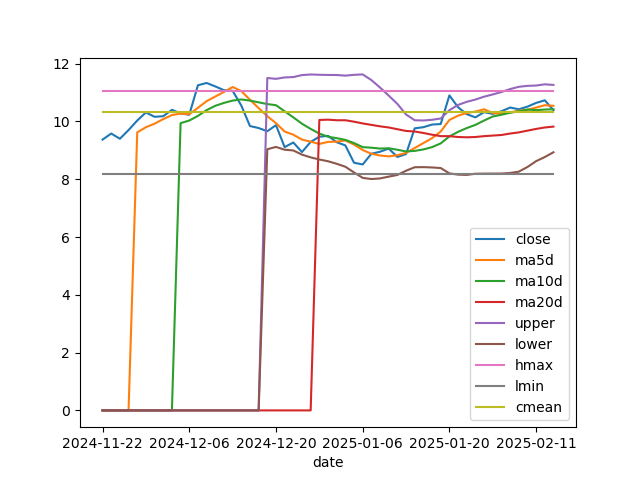

In [70]:
code
tdf = tdd.get_tdx_Exp_day_to_df(code, dl=60).sort_index(ascending=True)
cname = tdd.get_sina_data_code(code)
# plt.title(
#     stock_code + " | " + cname + " | " + str(quotes.index[-1])[: 10],
#     fontsize=14)
tdf.loc[:, ["close", "ma5d", "ma10d", "ma20d",
            "upper", "lower", "hmax", 'lmin', 'cmean']].plot()

In [71]:
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][-1:]

,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
date,,,,,,,,,
2025-02-13,-1.1,1.3,1.3,0.1,1.2,1.3,0.0,0.2,0.0


In [72]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][-1:]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
date,,,,,,,,,
2025-02-13,-3.2,0.8,1.2,0.9,-0.6,1.3,0.9,-0.6,1.8
